# DSO 522: Applied Time Series Analysis for Forecasting

## Week 13: Advanced forecasting methods

### Fall 2024

#### Instructor: Dr. Matteo Sesia

<p align="center">
  <img src="img/marshall.png" alt="Marshall School of Business" width="600"/>
</p>

<link rel="stylesheet" type="text/css" href="custom.css">

# Interactive slides

These lecture slides are made using an interactive [Jupyter](https://jupyter.org/) notebook, powered by the [RISE](https://rise.readthedocs.io/en/latest/) extension.

In the lectures, we will run `R` code in Jupyter, using the `fpp3` package (which you should have already installed).

In [1]:
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))

library(repr)
options(repr.matrix.max.rows=4)
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 250)
options(repr.matrix.max.rows = 10)

## The Prophet model

A recent proposal is the Prophet model, available via the `fable.prophet` package.

This model was introduced by Facebook (S. J. Taylor & Letham, 2018), originally for forecasting daily data with weekly and yearly seasonality, plus holiday effects. 

It was later extended to cover more types of seasonal data. 

It works best with time series that have strong seasonality and several seasons of historical data.

https://facebook.github.io/prophet/

In [2]:
library(fable.prophet)

Loading required package: Rcpp



## The Prophet model

Prophet can be considered a nonlinear regression model, of the form 
$$
y_t = g(t) + s(t) + h(t) + \varepsilon_t,
$$
where 
- $g(t)$ describes a piecewise-linear trend (or “growth term”),
- $s(t)$ describes the various seasonal patterns, 
- $h(t)$ captures the holiday effects, and
- $\varepsilon_t$ is a white noise error term.

**Fully automatic** Get a reasonable forecast on messy data with no manual effort. Prophet is robust to outliers, missing data, and dramatic changes in your time series.

## Example: Quarterly cement production

In [3]:
cement <- aus_production |>
  filter(year(Quarter) >= 1988)

cement

Quarter Beer Tobacco Bricks Cement Electricity Gas
1  1988 Q1 474  6034    428    1418   33142       116
2  1988 Q2 440  7389    519    1625   34664       137
3  1988 Q3 447  7077    555    1770   37154       157
4  1988 Q4 598  6837    538    1791   35303       125
5  1989 Q1 467  6051    510    1621   36905       117
⋮  ⋮       ⋮    ⋮       ⋮      ⋮      ⋮           ⋮  
86 2009 Q2 398  NA      NA     2160   57471       238
87 2009 Q3 419  NA      NA     2325   58394       252
88 2009 Q4 488  NA      NA     2273   57336       210
89 2010 Q1 414  NA      NA     1904   58309       205
90 2010 Q2 374  NA      NA     2401   58041       236

In [4]:
cement_train <- cement |>
  filter(year(Quarter) <= 2007)

fit <- cement_train |>
  model(
    arima = ARIMA(Cement),
    ets = ETS(Cement),
    prophet = prophet(Cement ~ season(period = 4))
  )

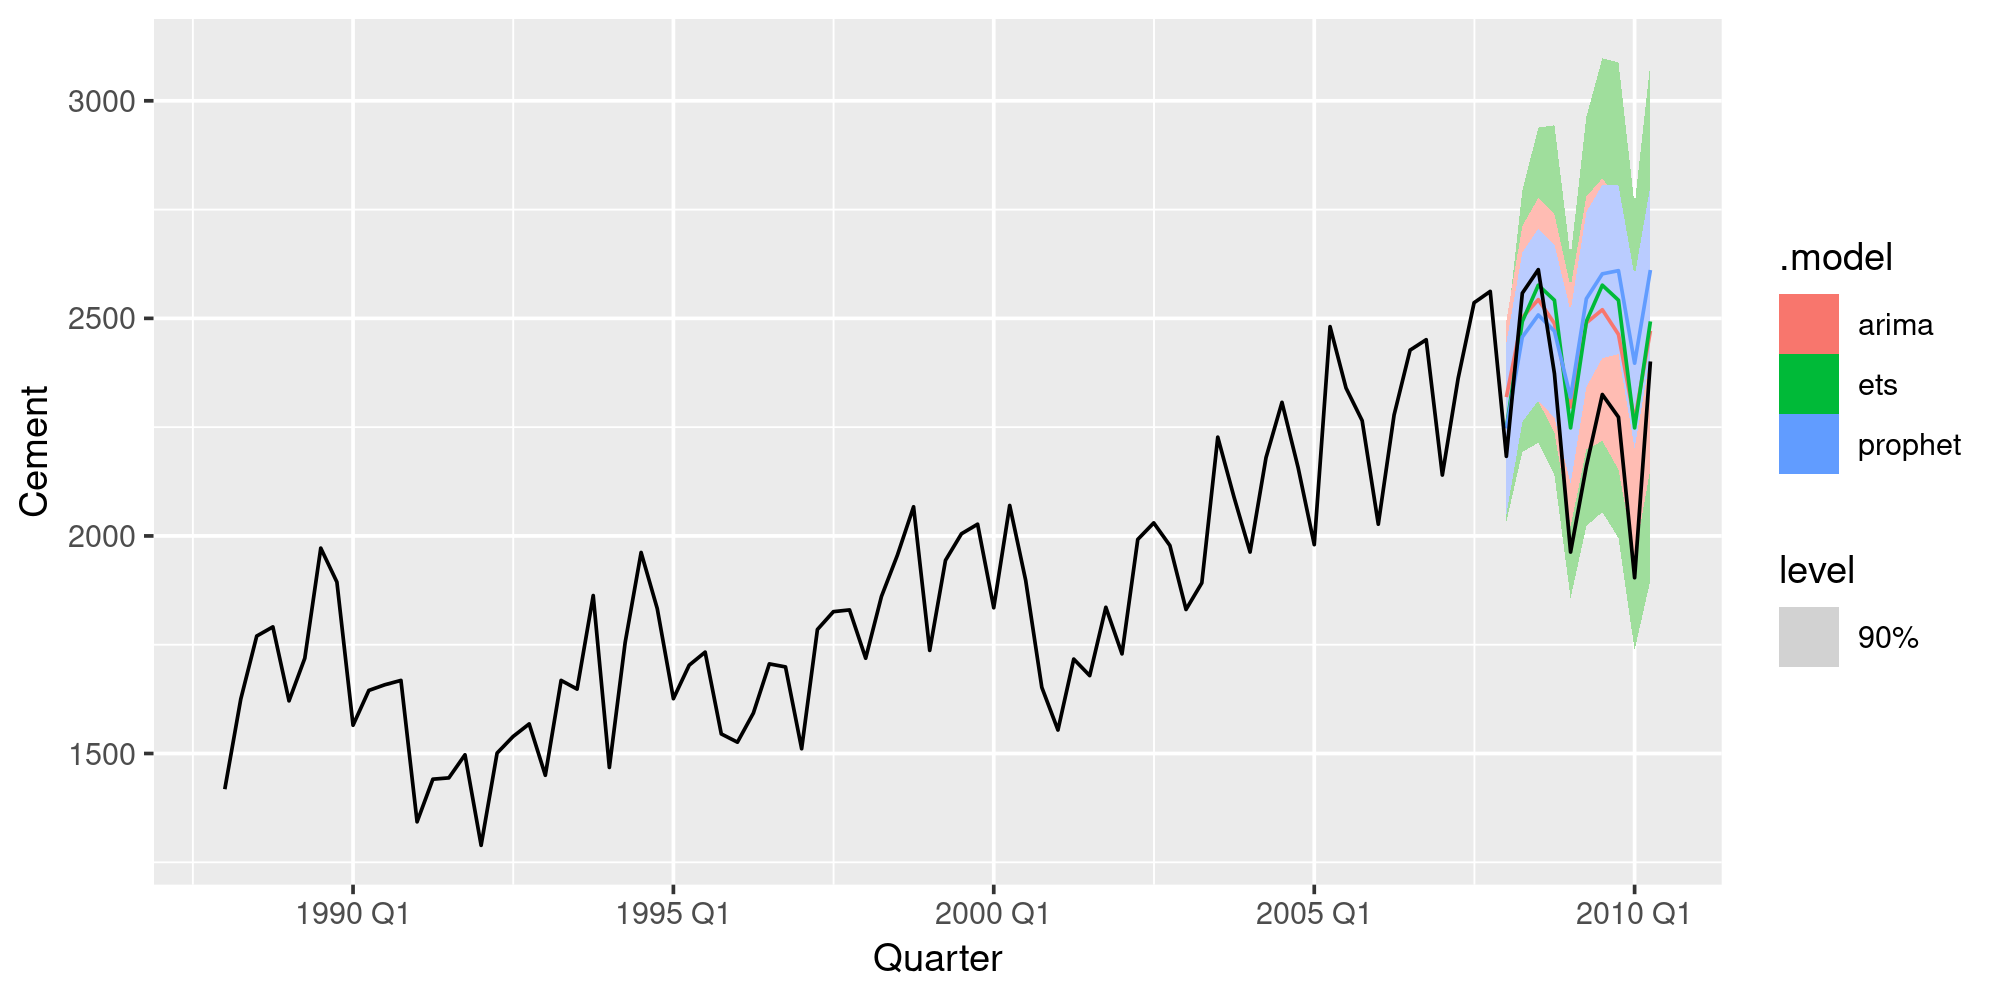

In [5]:
fc <- fit |> forecast(h = "2 years 6 months")
fc |> autoplot(cement, level=90)

In [6]:
fc |> accuracy(cement)

.model  .type ME        RMSE     MAE      MPE       MAPE      MASE    
1 arima   Test  -160.5363 216.4332 185.5033 -7.711827  8.676720 1.267373
2 ets     Test  -170.8256 222.0420 190.9648 -8.070537  8.852066 1.304686
3 prophet Test  -201.4193 280.4714 242.4174 -9.642948 11.228854 1.656214
  RMSSE    ACF1     
1 1.258787 0.3870161
2 1.291409 0.5793787
3 1.631237 0.6407620

In this example, the Prophet forecasts are worse than either the ETS or ARIMA forecasts.

## Example: Electricity demand

In [7]:
vic_elec

Time                Demand   Temperature Date       Holiday
1     2012-01-01 00:00:00 4382.825 21.40       2012-01-01 TRUE   
2     2012-01-01 00:30:00 4263.366 21.05       2012-01-01 TRUE   
3     2012-01-01 01:00:00 4048.966 20.70       2012-01-01 TRUE   
4     2012-01-01 01:30:00 3877.563 20.55       2012-01-01 TRUE   
5     2012-01-01 02:00:00 4036.230 20.40       2012-01-01 TRUE   
⋮     ⋮                   ⋮        ⋮           ⋮          ⋮      
52604 2014-12-31 21:30:00 3873.449 19.0        2014-12-31 FALSE  
52605 2014-12-31 22:00:00 3791.637 18.5        2014-12-31 FALSE  
52606 2014-12-31 22:30:00 3724.836 17.7        2014-12-31 FALSE  
52607 2014-12-31 23:00:00 3761.887 17.3        2014-12-31 FALSE  
52608 2014-12-31 23:30:00 3809.415 17.1        2014-12-31 FALSE

In [8]:
elec <- vic_elec |>
  mutate(
    DOW = wday(Date, label = TRUE),
    Working_Day = !Holiday & !(DOW %in% c("Sat", "Sun")),
    Cooling = pmax(Temperature, 18)
  )

elec

Time                Demand   Temperature Date       Holiday DOW
1     2012-01-01 00:00:00 4382.825 21.40       2012-01-01 TRUE    Sun
2     2012-01-01 00:30:00 4263.366 21.05       2012-01-01 TRUE    Sun
3     2012-01-01 01:00:00 4048.966 20.70       2012-01-01 TRUE    Sun
4     2012-01-01 01:30:00 3877.563 20.55       2012-01-01 TRUE    Sun
5     2012-01-01 02:00:00 4036.230 20.40       2012-01-01 TRUE    Sun
⋮     ⋮                   ⋮        ⋮           ⋮          ⋮       ⋮  
52604 2014-12-31 21:30:00 3873.449 19.0        2014-12-31 FALSE   Wed
52605 2014-12-31 22:00:00 3791.637 18.5        2014-12-31 FALSE   Wed
52606 2014-12-31 22:30:00 3724.836 17.7        2014-12-31 FALSE   Wed
52607 2014-12-31 23:00:00 3761.887 17.3        2014-12-31 FALSE   Wed
52608 2014-12-31 23:30:00 3809.415 17.1        2014-12-31 FALSE   Wed
      Working_Day Cooling
1     FALSE       21.40  
2     FALSE       21.05  
3     FALSE       20.70  
4     FALSE       20.55  
5     FALSE       20.40  
⋮     ⋮           ⋮      
52604 TRUE        19.0   
52605 TRUE        18.5   
52606 TRUE        18.0   
52607 TRUE        18.0   
52608 TRUE        18.0

In [9]:
elec

Time                Demand   Temperature Date       Holiday DOW
1     2012-01-01 00:00:00 4382.825 21.40       2012-01-01 TRUE    Sun
2     2012-01-01 00:30:00 4263.366 21.05       2012-01-01 TRUE    Sun
3     2012-01-01 01:00:00 4048.966 20.70       2012-01-01 TRUE    Sun
4     2012-01-01 01:30:00 3877.563 20.55       2012-01-01 TRUE    Sun
5     2012-01-01 02:00:00 4036.230 20.40       2012-01-01 TRUE    Sun
⋮     ⋮                   ⋮        ⋮           ⋮          ⋮       ⋮  
52604 2014-12-31 21:30:00 3873.449 19.0        2014-12-31 FALSE   Wed
52605 2014-12-31 22:00:00 3791.637 18.5        2014-12-31 FALSE   Wed
52606 2014-12-31 22:30:00 3724.836 17.7        2014-12-31 FALSE   Wed
52607 2014-12-31 23:00:00 3761.887 17.3        2014-12-31 FALSE   Wed
52608 2014-12-31 23:30:00 3809.415 17.1        2014-12-31 FALSE   Wed
      Working_Day Cooling
1     FALSE       21.40  
2     FALSE       21.05  
3     FALSE       20.70  
4     FALSE       20.55  
5     FALSE       20.40  
⋮     ⋮           ⋮      
52604 TRUE        19.0   
52605 TRUE        18.5   
52606 TRUE        18.0   
52607 TRUE        18.0   
52608 TRUE        18.0

In [10]:
elec_train <- elec |> filter(Time <= max(Time)-weeks(1))
elec_test  <- elec |> filter(Time > max(Time)-weeks(1))

In [11]:
fit <- elec_train |>
     model(prophet(Demand ~ Temperature + Cooling + Working_Day + 
                   season(period = "day") + 
                   season(period = "week") +
                   season(period = "year"))
           )

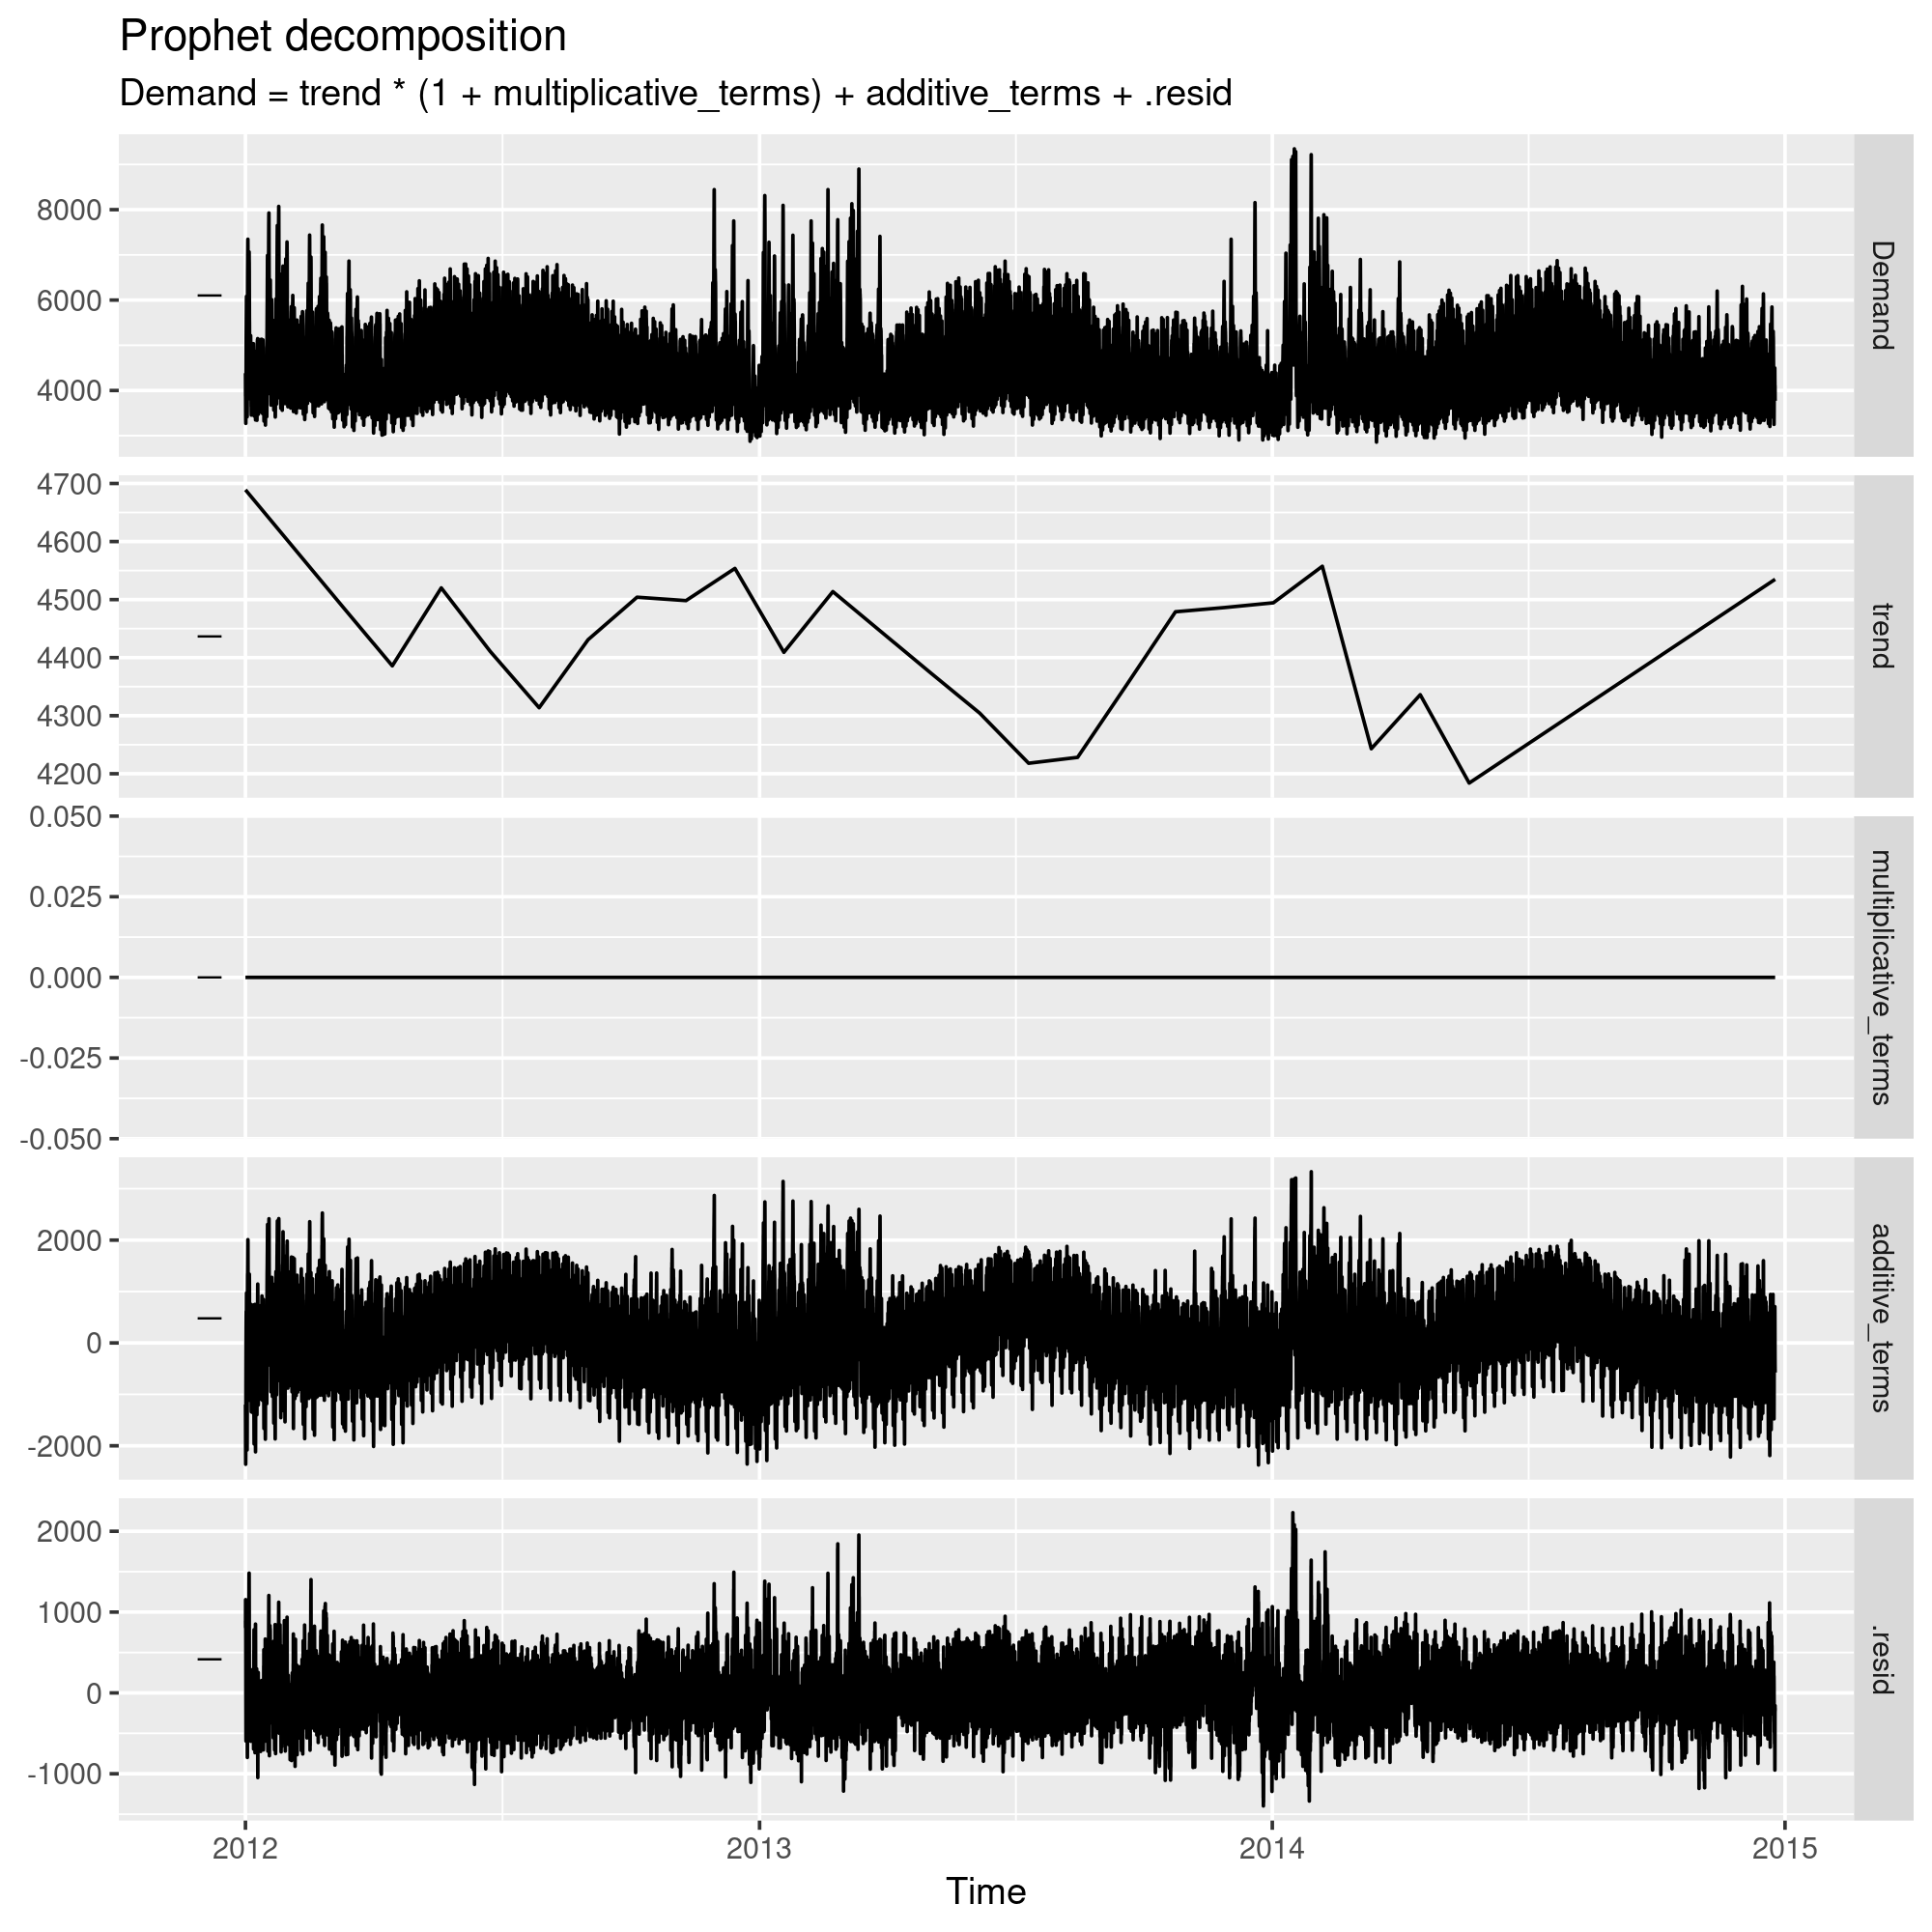

In [12]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 250)

fit |>
  components() |>
  autoplot()

The Prophet model uses a piecewise linear time trend which is not really appropriate here as we don’t expect the long term forecasts to continue to follow the |linear trend at the end of the series.

Let's look at the residuals.

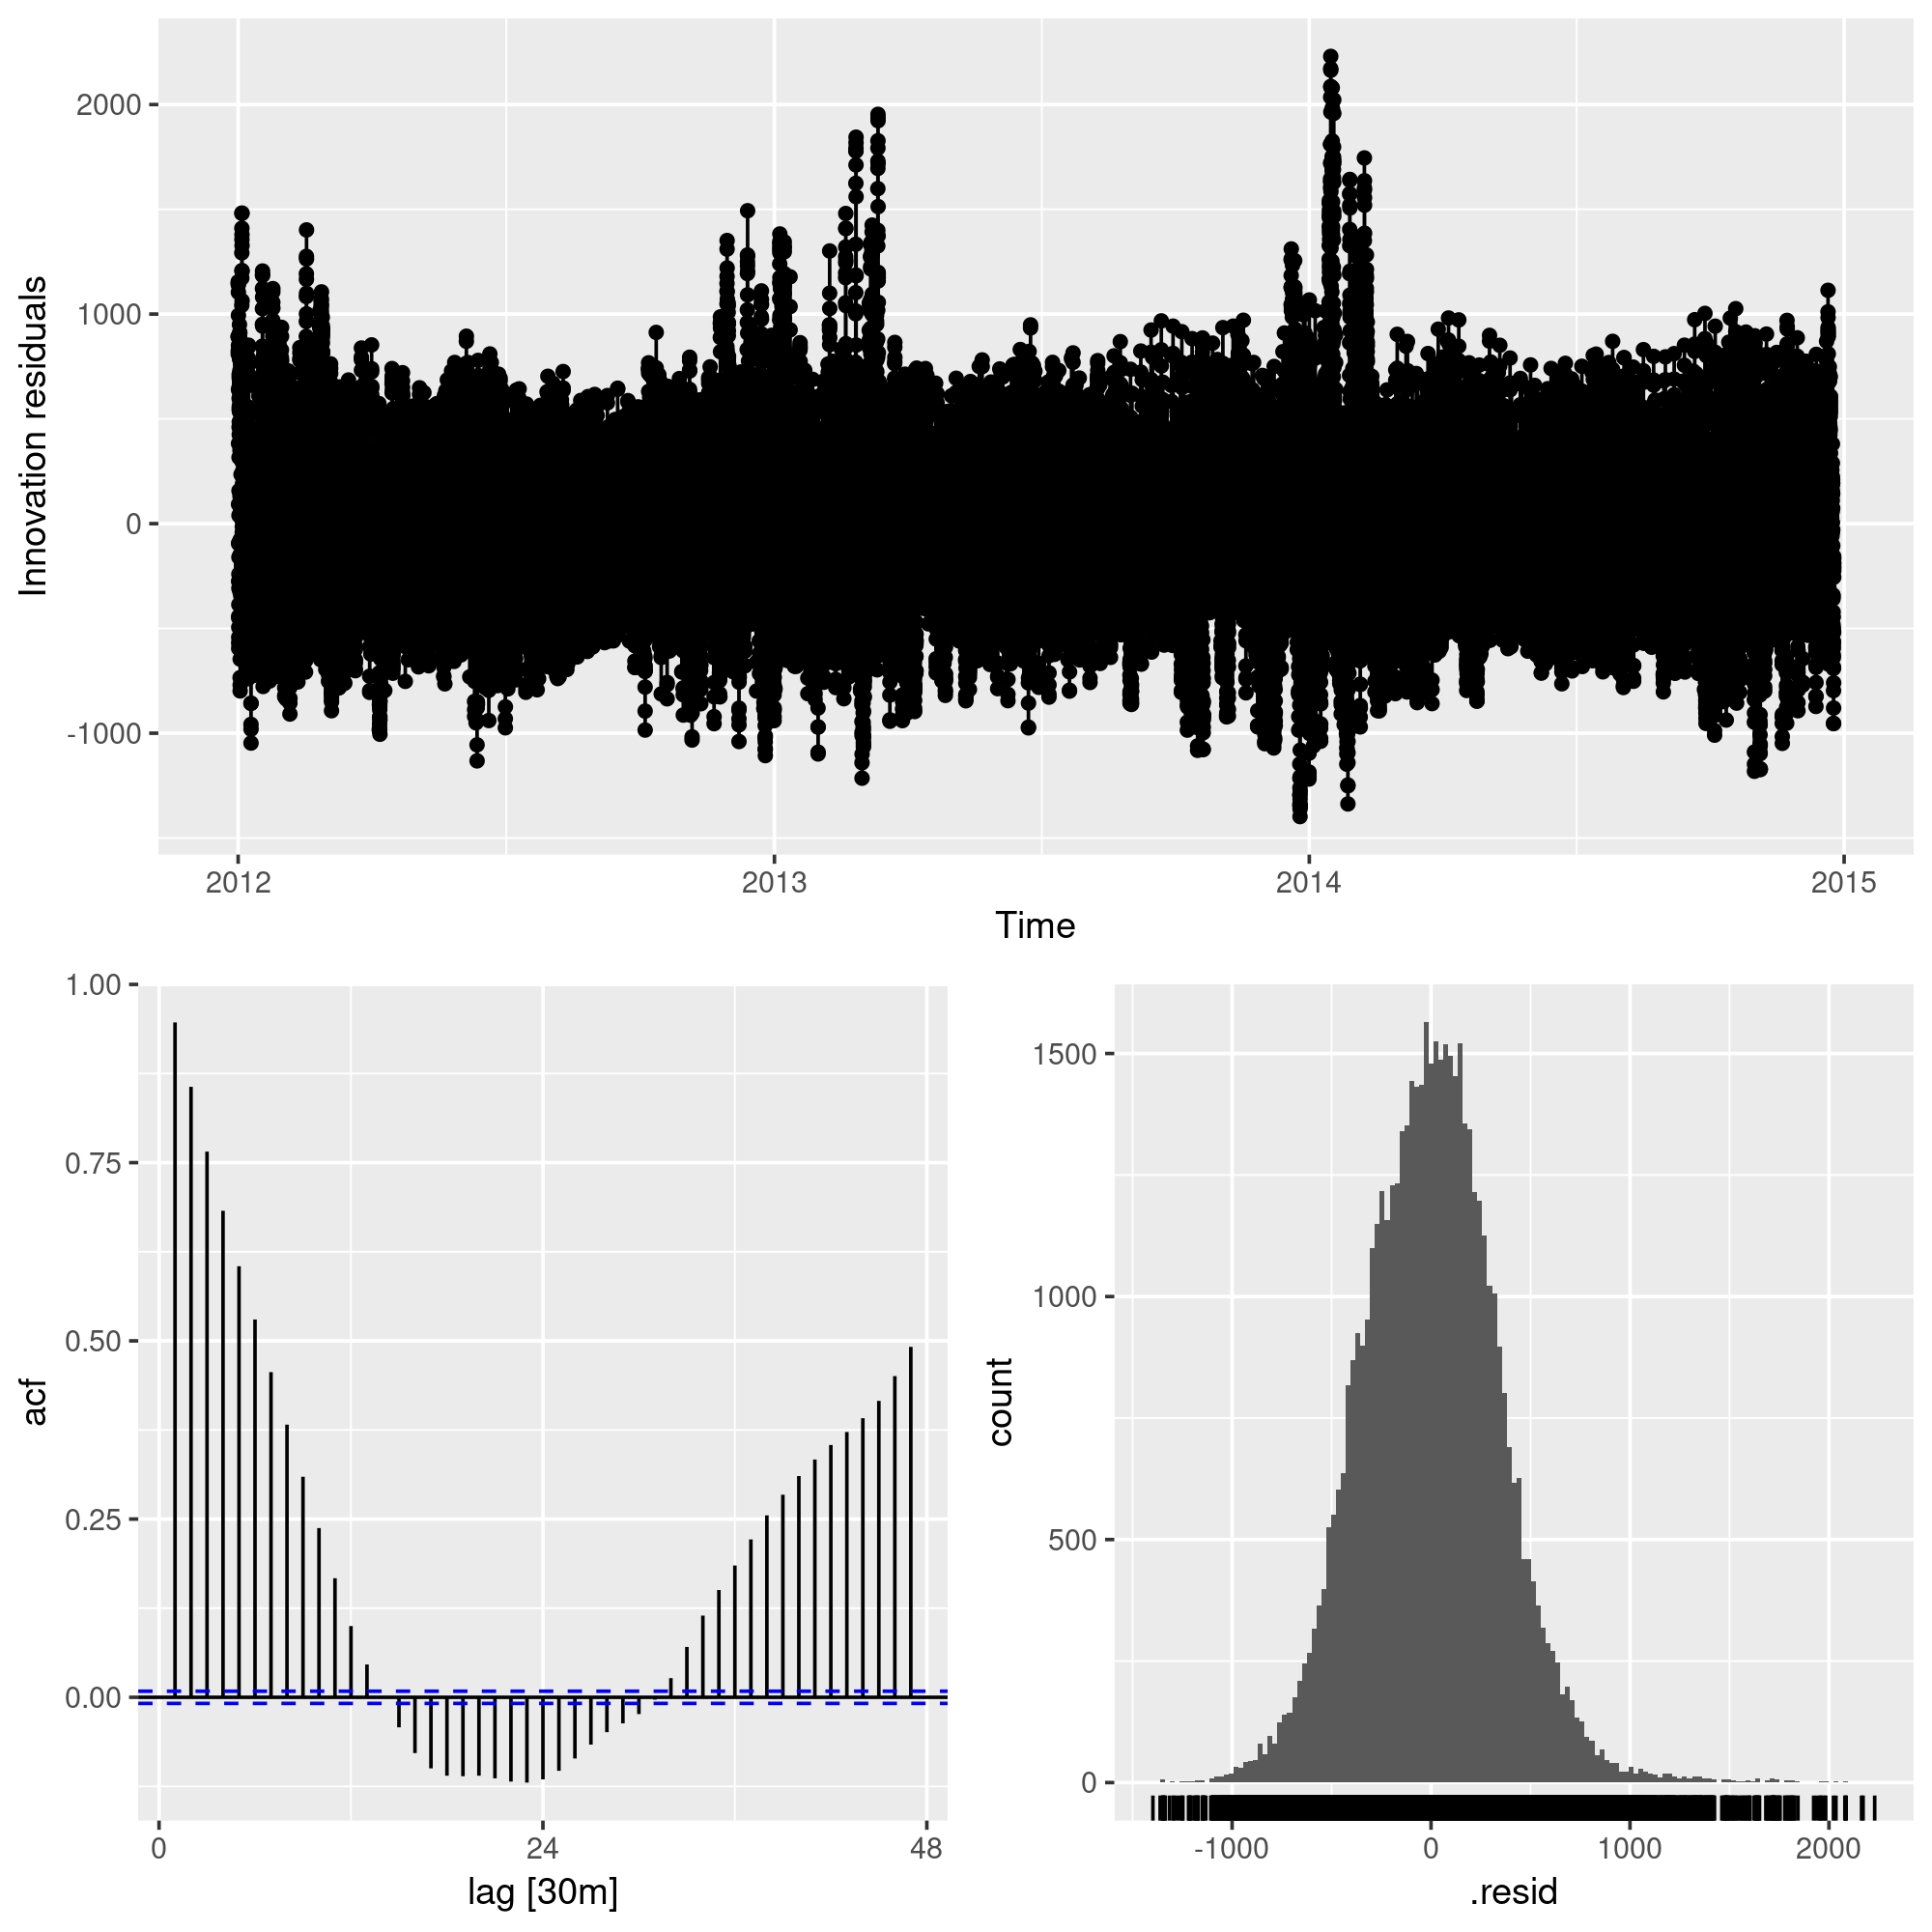

In [13]:
fit |> gg_tsresiduals()

There is also substantial remaining autocorrelation in the residuals,

In [14]:
fc <- fit |>
  forecast(new_data = elec_test)

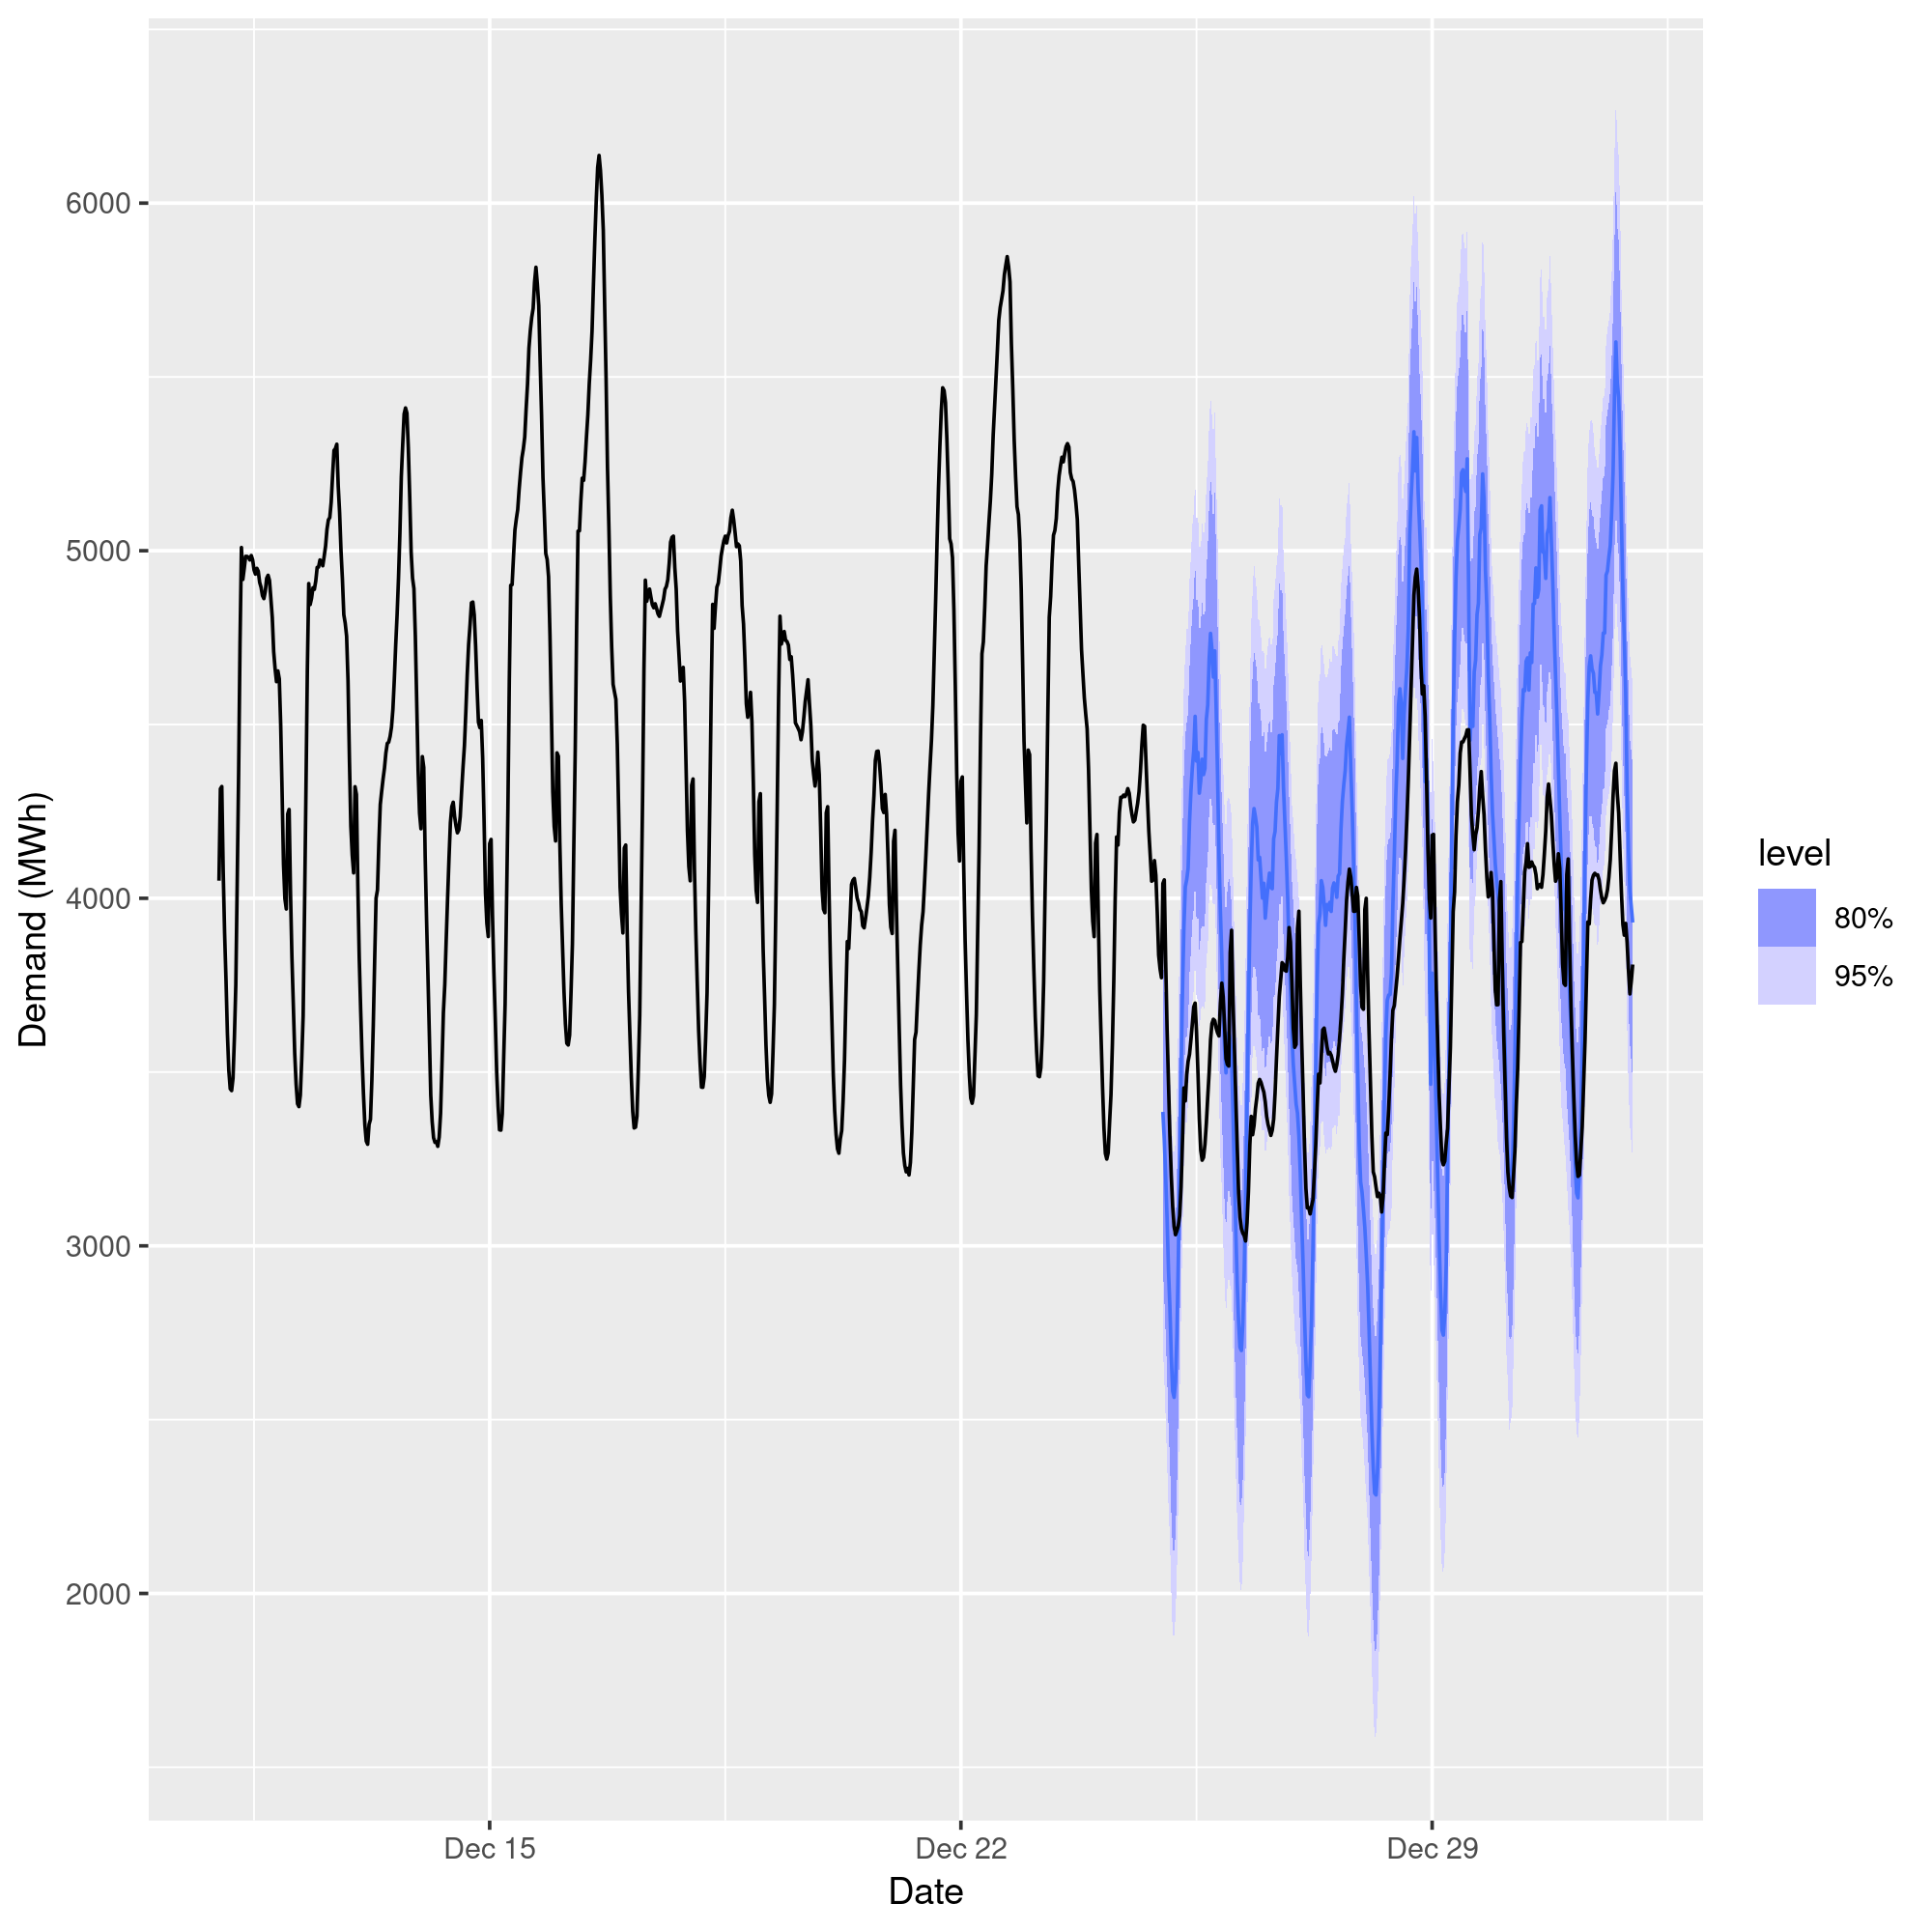

In [15]:
fc |>
  autoplot(elec |> filter(Time >= max(Time)-weeks(3)) ) +
  labs(x = "Date", y = "Demand (MWh)")

In [16]:
fc |> accuracy(elec_test)

.model                                                                                                                                  
1 prophet(Demand ~ Temperature + Cooling + Working_Day + season(period = "day") + \n    season(period = "week") + season(period = "year"))
  .type ME        RMSE     MAE      MPE       MAPE     MASE RMSSE ACF1    
1 Test  -298.8315 588.8865 514.4652 -7.567108 13.73217 NaN  NaN   0.968413

## Conclusions about Prophet

Prophet is fast to estimate and it is completely automated.

However, it rarely gives better forecast accuracy than the alternative approaches.

## Modeling complex seasonality

So far, besides Prophet, we have mostly considered relatively simple seasonal patterns such as quarterly and monthly data. 

However, higher frequency time series often exhibit more complicated seasonal patterns.

For example, daily data may have a weekly pattern as well as an annual pattern. 

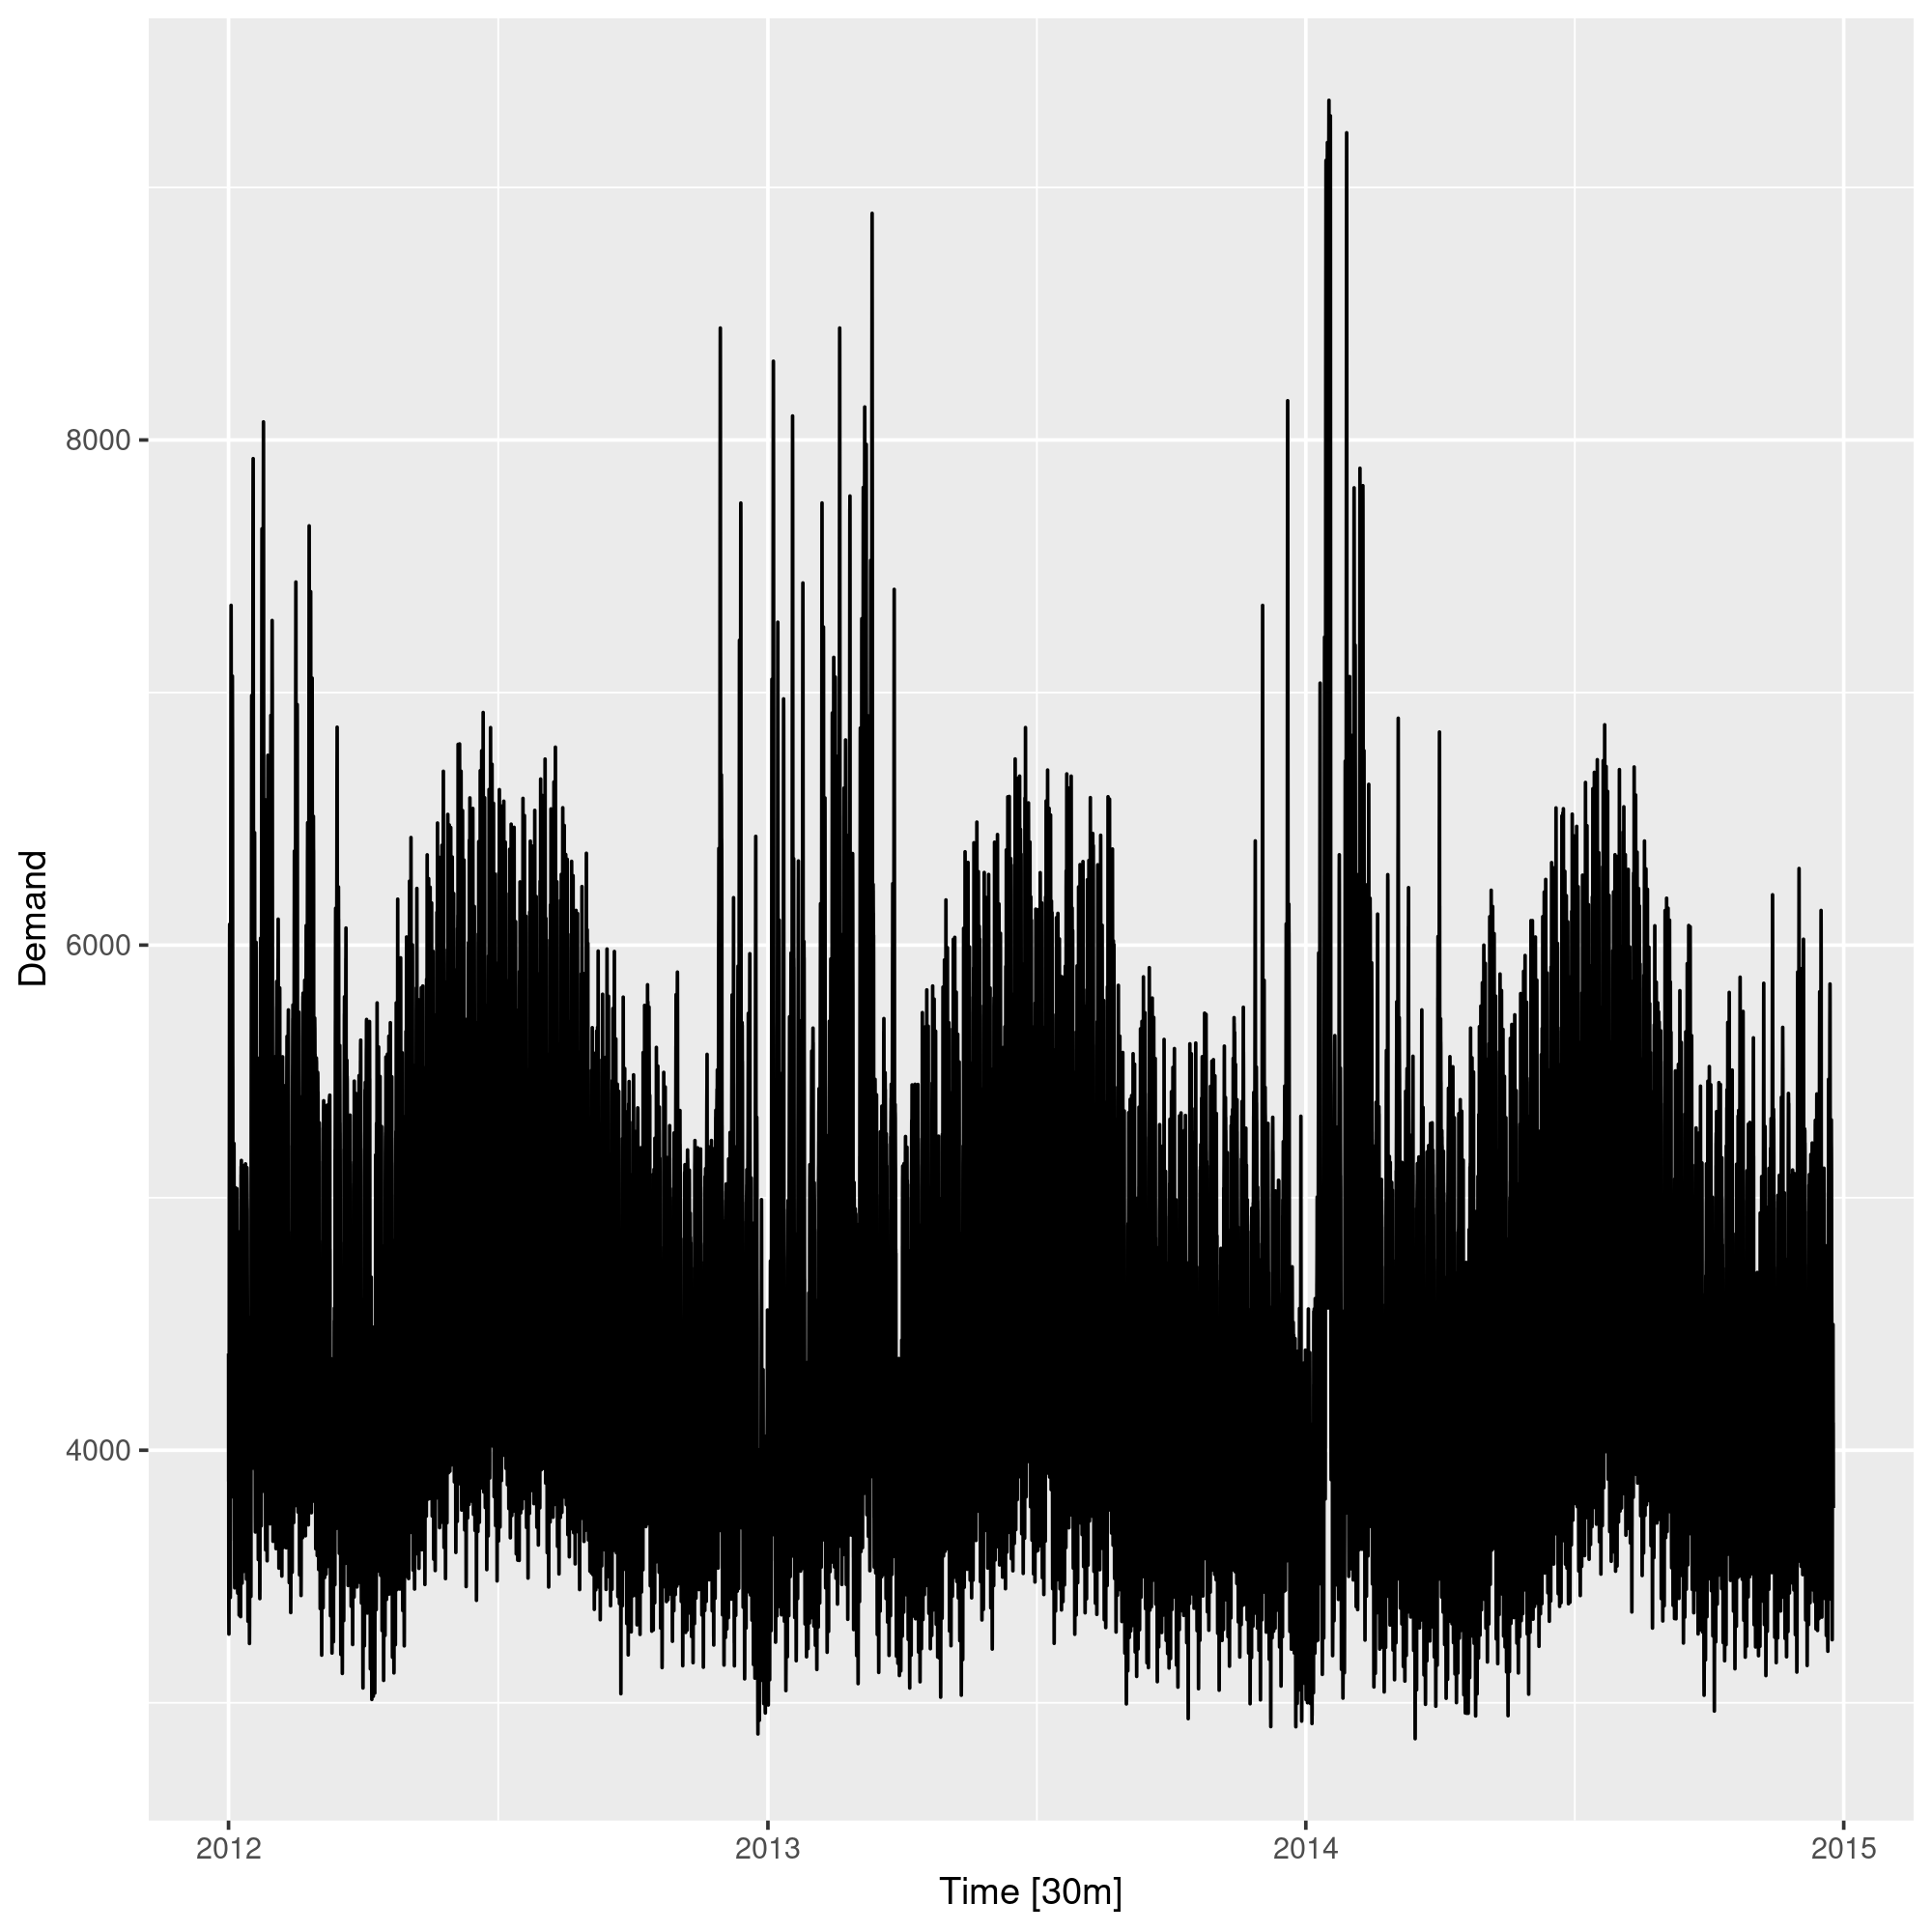

In [17]:
elec_train |> autoplot(Demand)

## STL with multiple seasonal periods

The `STL()` function is designed to deal with multiple seasonality. 

It will return multiple seasonal components, as well as a trend and remainder component. 

In this case, we need to re-index the tsibble to avoid the missing values, and then explicitly give the seasonal periods.

In [18]:
fit <- elec_train |>
    model(STL(Demand ~ season(period = "day") + 
                       season(period = "week") +
                       season(period = "year")
              ))

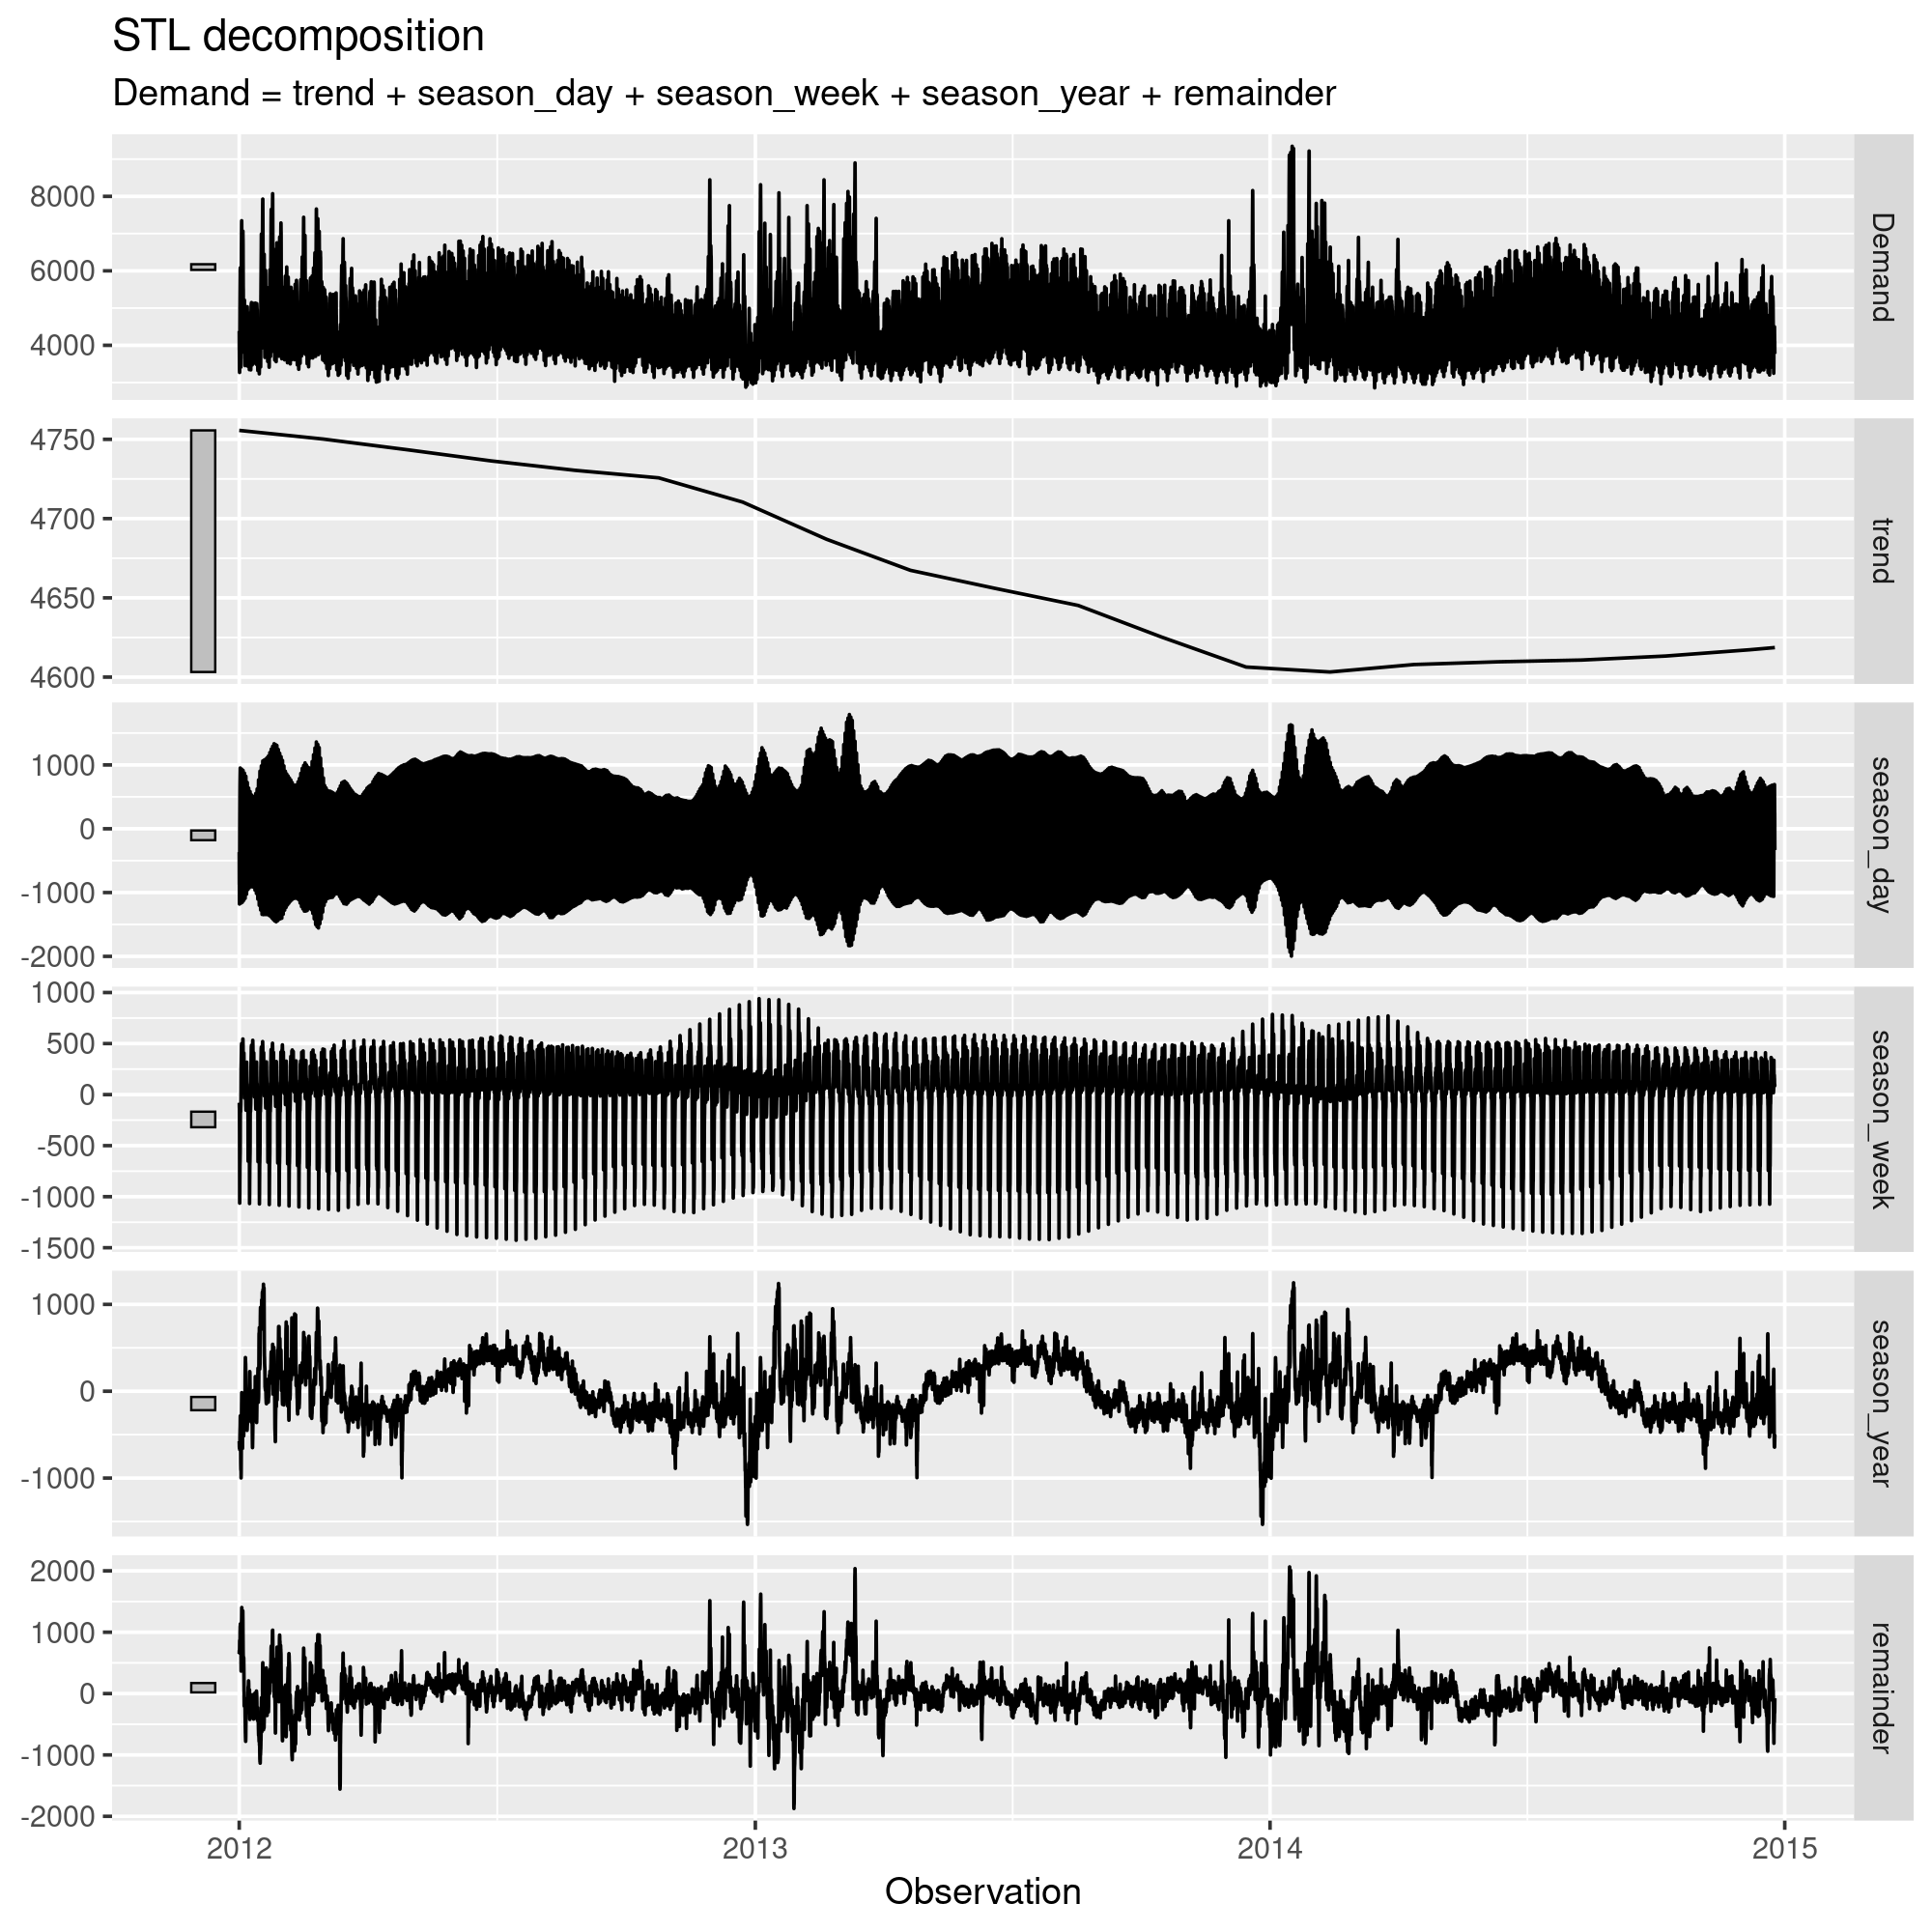

In [19]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 250)

fit |>
    components() |>
    autoplot() + labs(x = "Observation")

There are three seasonal patterns shown here.

To properly interpret this graph, it is important to notice the vertical scales.

The decomposition can also be used in forecasting, with each of the seasonal components forecast using a seasonal naïve method, and the seasonally adjusted data forecast using ETS.

In [20]:
# Forecasts from STL+ETS decomposition
my_dcmp_spec <- decomposition_model(
    STL(Demand ~ season(period = "day") + 
                 season(period = "week") +
                 season(period = "year"),
        robust = TRUE),
    ETS(season_adjust ~ season("N"))
    )

In [21]:
fit <- elec_train |>
    model(my_dcmp_spec)

In [22]:
fc <- fit |>
  forecast(new_data = elec_test)

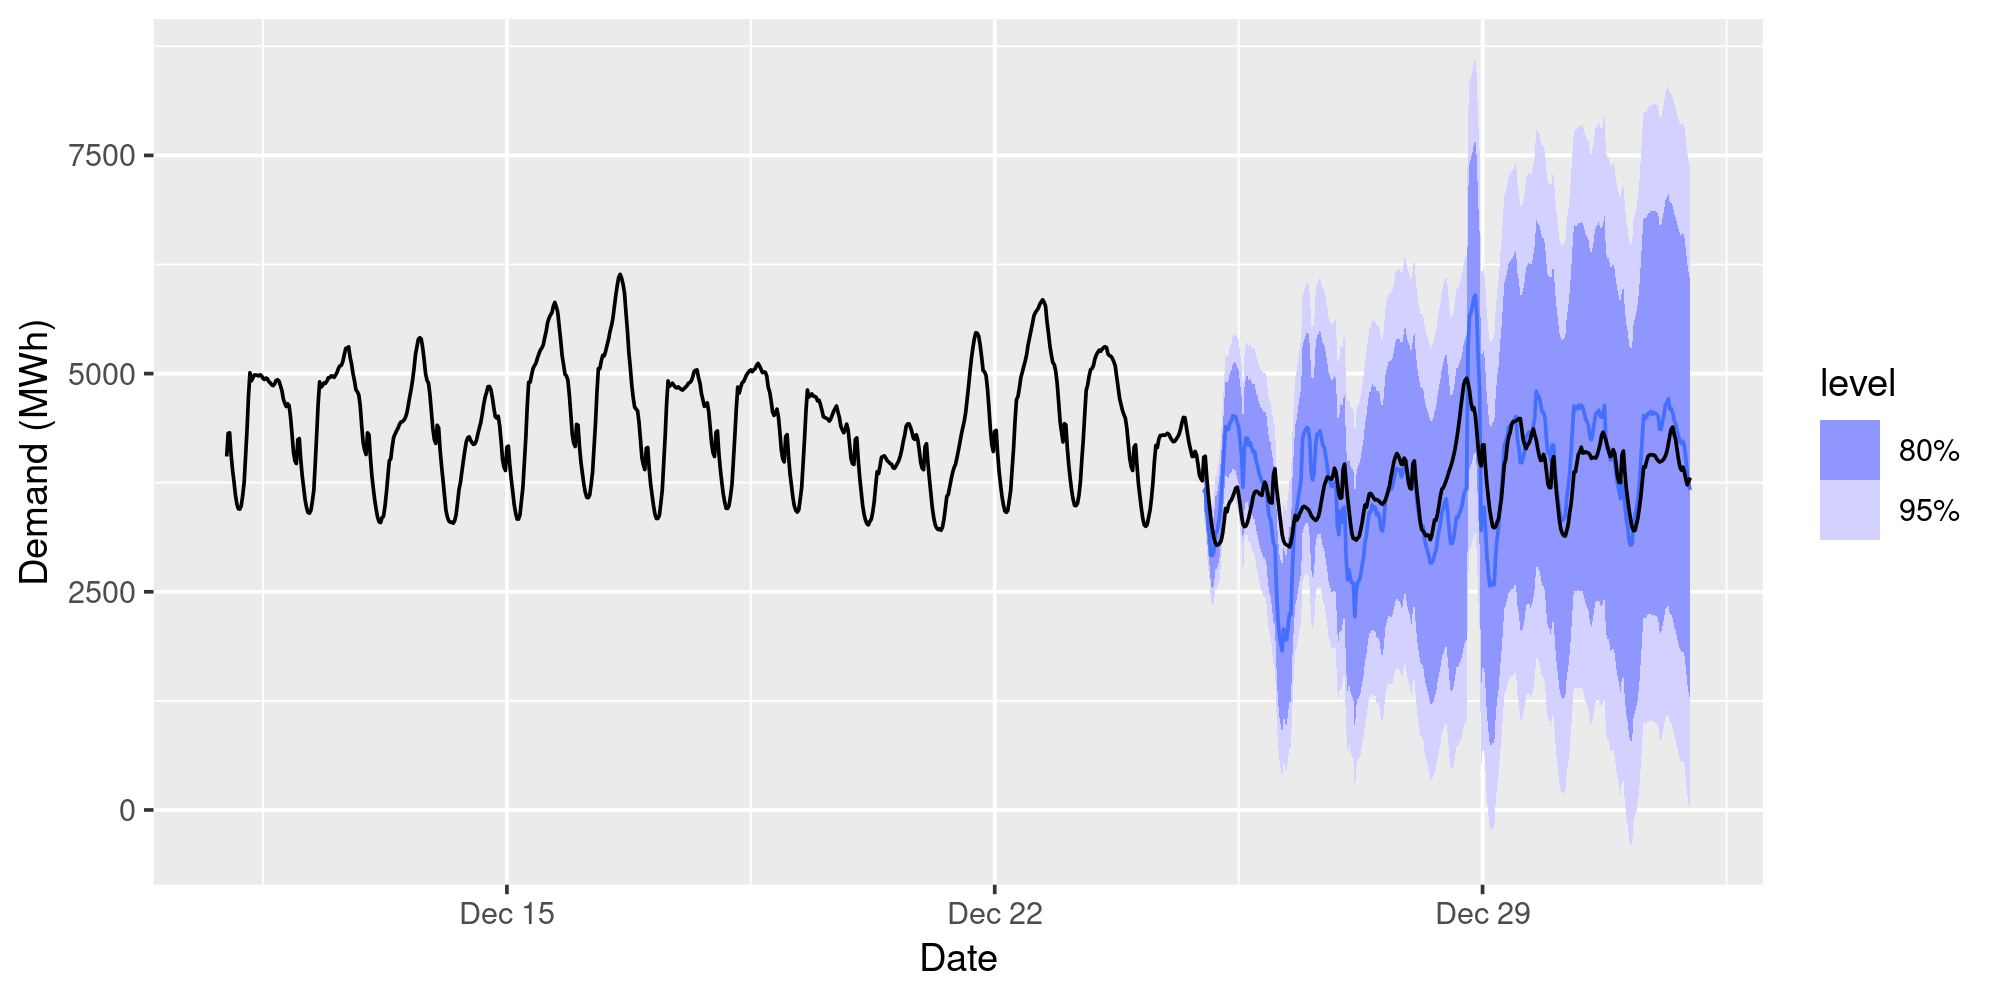

In [23]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 250)

fc |>
  autoplot(elec |> filter(Time >= max(Time)-weeks(3)) ) +
  labs(x = "Date", y = "Demand (MWh)")

In [24]:
fc |> accuracy(elec_test)

.model       .type ME        RMSE     MAE      MPE        MAPE     MASE RMSSE
1 my_dcmp_spec Test  -36.56187 542.7591 428.0206 -0.8389168 11.56824 NaN  NaN  
  ACF1     
1 0.9472644

## Fourier features

An alternative to using seasonal dummy variables, especially for long seasonal periods, is to use Fourier terms. 

Jean-Baptiste Fourier was a French mathematician, born in the 1700s, who showed that a series of sine and cosine terms of the right frequencies can approximate any periodic function. We can use them for seasonal patterns.

If $m$ is the seasonal period, then the first few Fourier terms are given by 
$$
x_{1,t} = \sin\left(\textstyle\frac{2\pi t}{m}\right),
  x_{2,t} = \cos\left(\textstyle\frac{2\pi t}{m}\right),
  x_{3,t} = \sin\left(\textstyle\frac{4\pi t}{m}\right),
$$
$$
x_{4,t} = \cos\left(\textstyle\frac{4\pi t}{m}\right),
  x_{5,t} = \sin\left(\textstyle\frac{6\pi t}{m}\right),
  x_{6,t} = \cos\left(\textstyle\frac{6\pi t}{m}\right),
$$
and so on. 

If we have monthly seasonality, and we use the first 11 of these predictor variables, then we will get exactly the same forecasts as using 11 dummy variables.

With Fourier terms, we often need fewer predictors than with dummy variables, especially when $m$ is large. 

This makes them useful for weekly data, for example, where $m=52$. 

For short seasonal periods (e.g., quarterly data), there is little advantage in using Fourier terms over seasonal dummy variables.

These Fourier terms are produced using the `fourier()` function. For example, the Australian beer data can be modelled like this.

The $K$ argument to `fourier()` specifies how many pairs of sin and cos terms to include. 

## Example: Electricity data

Time                Demand   Temperature Date       Holiday DOW Working_Day
1   2014-12-11 00:00:00 4314.853 17.6        2014-12-11 FALSE   Thu TRUE       
2   2014-12-11 00:30:00 4321.573 17.6        2014-12-11 FALSE   Thu TRUE       
3   2014-12-11 01:00:00 4077.981 17.5        2014-12-11 FALSE   Thu TRUE       
4   2014-12-11 01:30:00 3900.445 17.6        2014-12-11 FALSE   Thu TRUE       
5   2014-12-11 02:00:00 3765.163 17.6        2014-12-11 FALSE   Thu TRUE       
⋮   ⋮                   ⋮        ⋮           ⋮          ⋮       ⋮   ⋮          
668 2014-12-24 21:30:00 4066.325 17.8        2014-12-24 FALSE   Wed TRUE       
669 2014-12-24 22:00:00 3959.142 17.4        2014-12-24 FALSE   Wed TRUE       
670 2014-12-24 22:30:00 3836.342 17.0        2014-12-24 FALSE   Wed TRUE       
671 2014-12-24 23:00:00 3796.700 16.8        2014-12-24 FALSE   Wed TRUE       
672 2014-12-24 23:30:00 3771.574 16.6        2014-12-24 FALSE   Wed TRUE       
    Cooling
1   18     
2   18     
3   18     
4   18     
5   18     
⋮   ⋮      
668 18     
669 18     
670 18     
671 18     
672 18

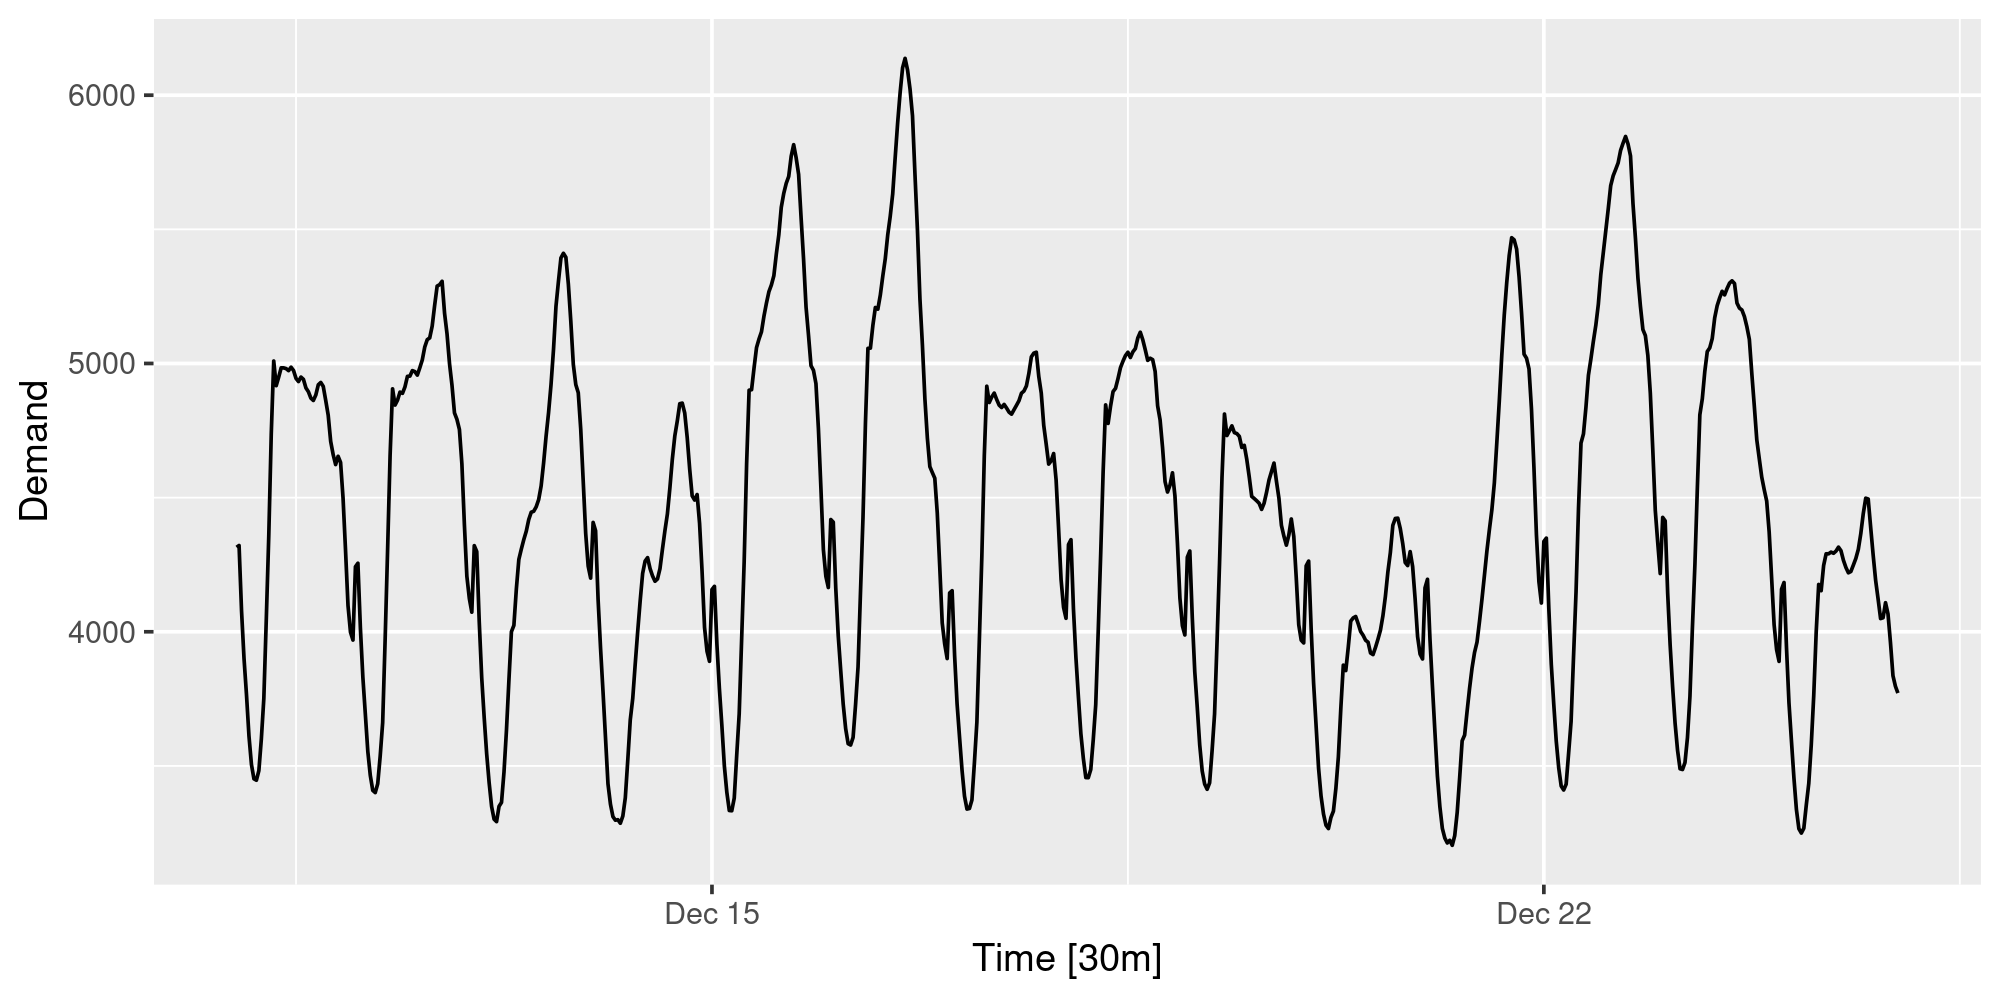

In [25]:
elec_train_small <- elec_train |> 
    filter(Time > max(Time)-weeks(2))

elec_train_small

elec_train_small |> 
    autoplot(Demand)

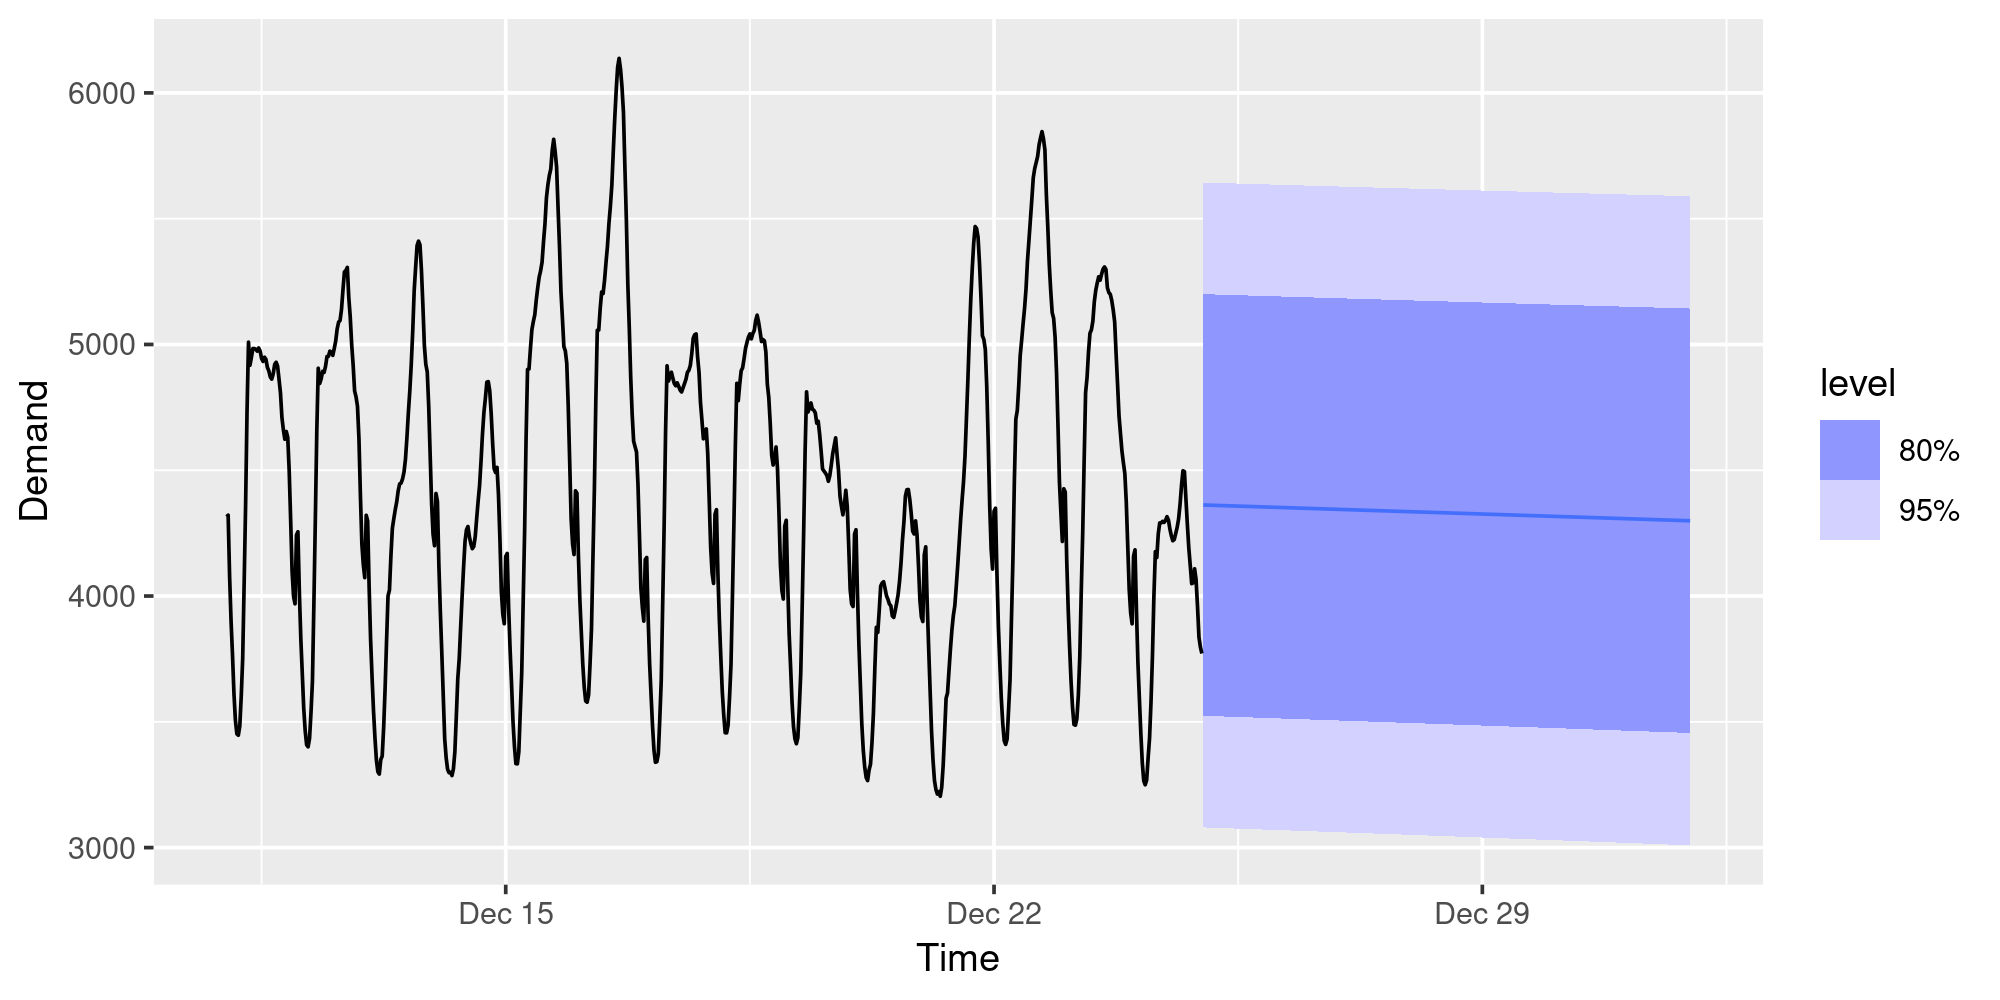

In [26]:
elec_train_small |>
    model(TSLM(Demand ~ trend())) |>
    forecast(h="1 week") |>
    autoplot(elec_train_small)

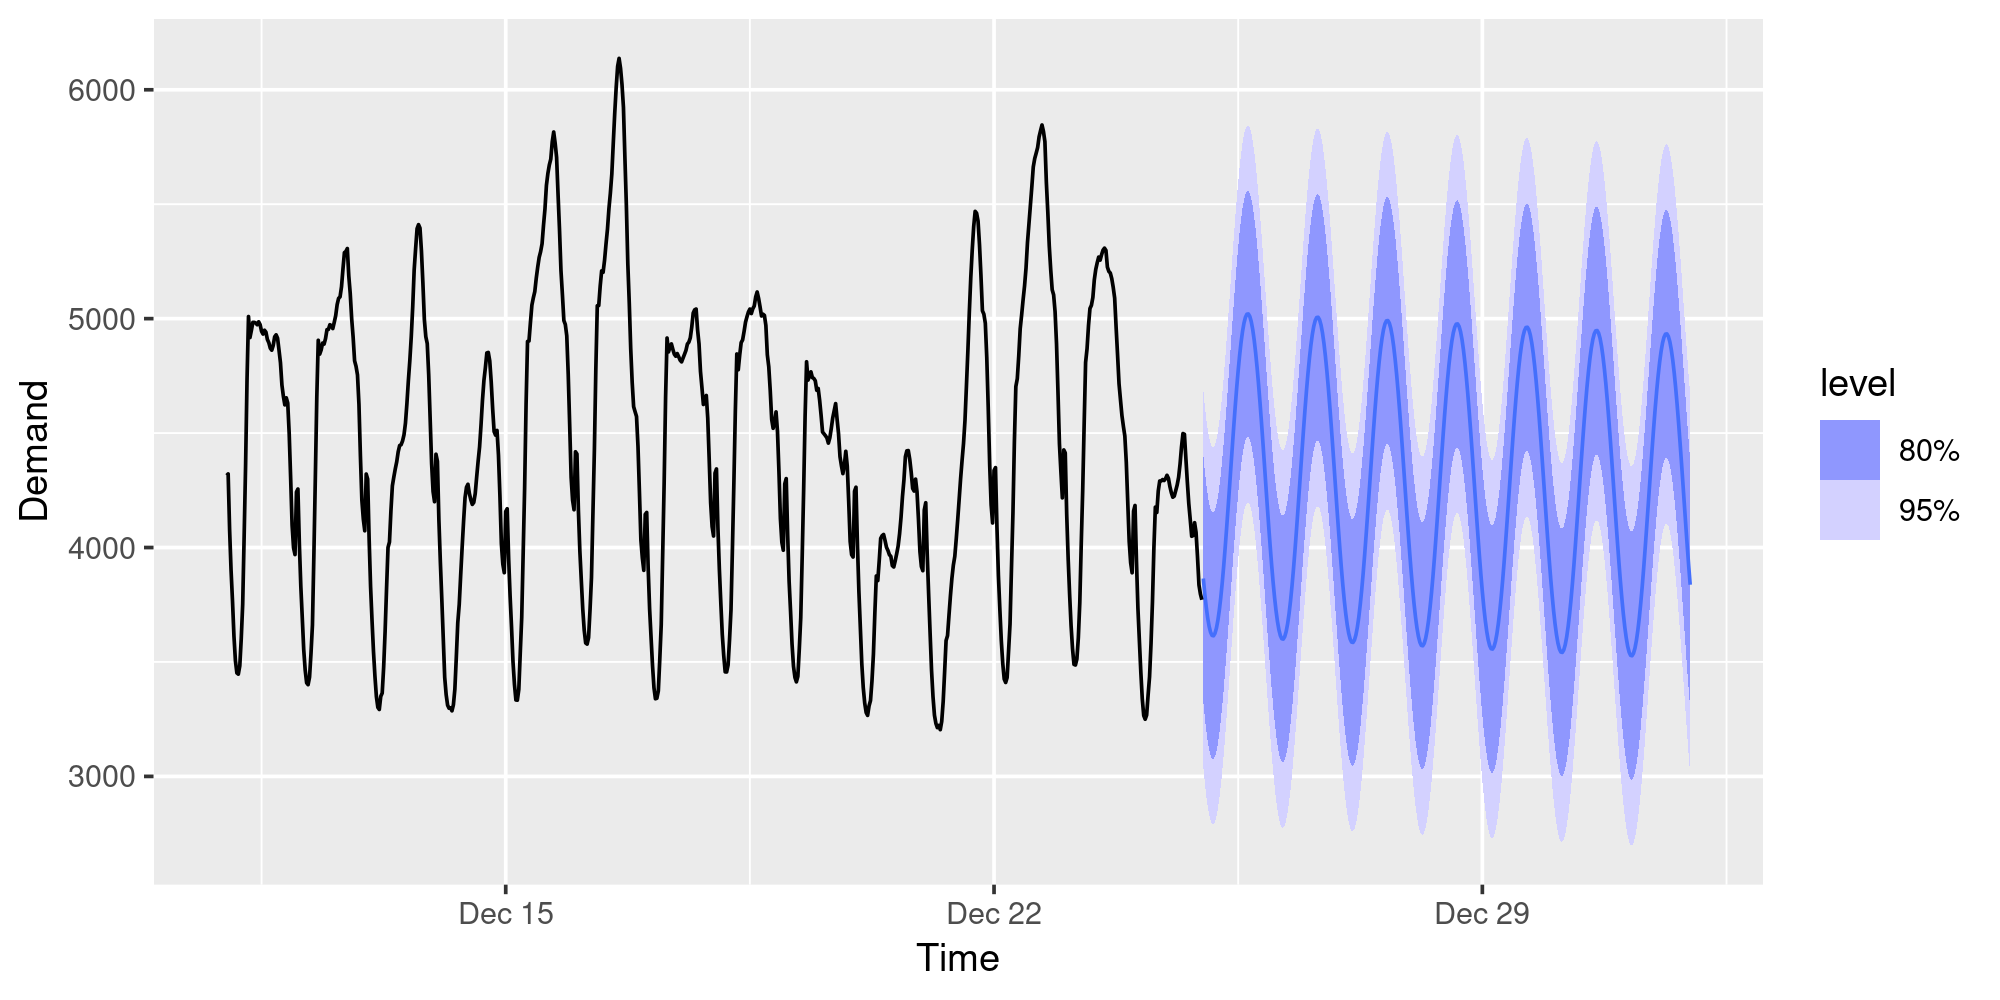

In [27]:
elec_train_small |>
    model(TSLM(Demand ~ trend() + fourier(period = "day", K = 1))) |>
    forecast(h="1 week") |>
    autoplot(elec_train_small)

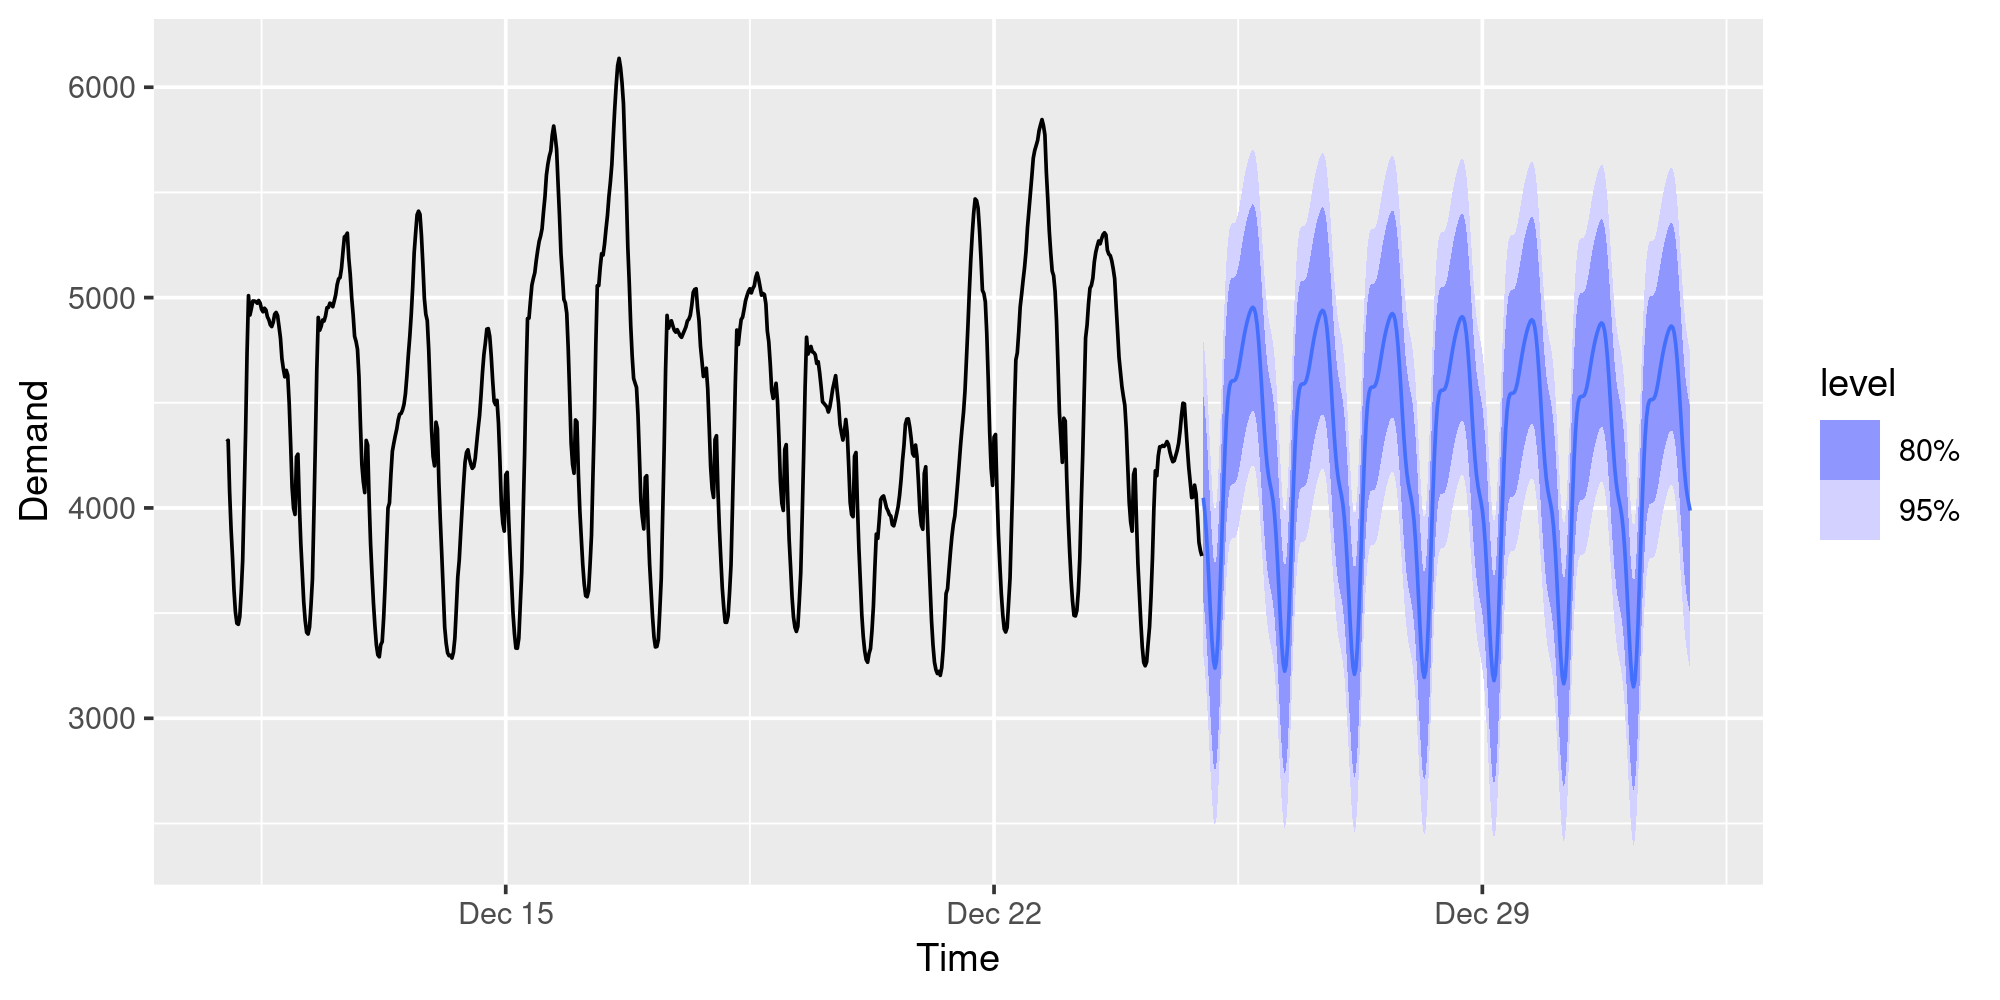

In [28]:
elec_train_small |>
    model(TSLM(Demand ~ trend() + fourier(period = "day", K = 4))) |>
    forecast(h="1 week") |>
    autoplot(elec_train_small)

## Dynamic harmonic regression with multiple seasonal periods

With multiple seasonalities, we can use Fourier terms. 

Because there are multiple seasonalities, we need to add Fourier terms for each seasonal period.

In [29]:
fit <- elec_train_small |>
  model(
    ARIMA(Demand ~ PDQ(0, 0, 0) + pdq(d = 0) +
          Temperature + Cooling + Working_Day +
          fourier(period = "day", K = 10) +
          fourier(period = "week", K = 5))
  )

Forecasting with such models is difficult because we require future values of the predictor variables. Future values of the Fourier terms are easy to compute, but future temperatures are, of course, unknown. If we are only interested in forecasting up to a week ahead, we could use temperature forecasts obtained from a meteorological model. Alternatively, we could use scenario forecasting 

In [30]:
elec_newdata <- new_data(elec_train_small, 2*48) |>
  mutate(
    Temperature = tail(elec$Temperature, 2 * 48),
    Date = lubridate::as_date(Time),
    DOW = wday(Date, label = TRUE),
    Working_Day = (Date != "2015-01-01") &
                   !(DOW %in% c("Sat", "Sun")),
    Cooling = pmax(Temperature, 18)
  )

In [31]:
fc <- fit |>
  forecast(new_data = elec_newdata)

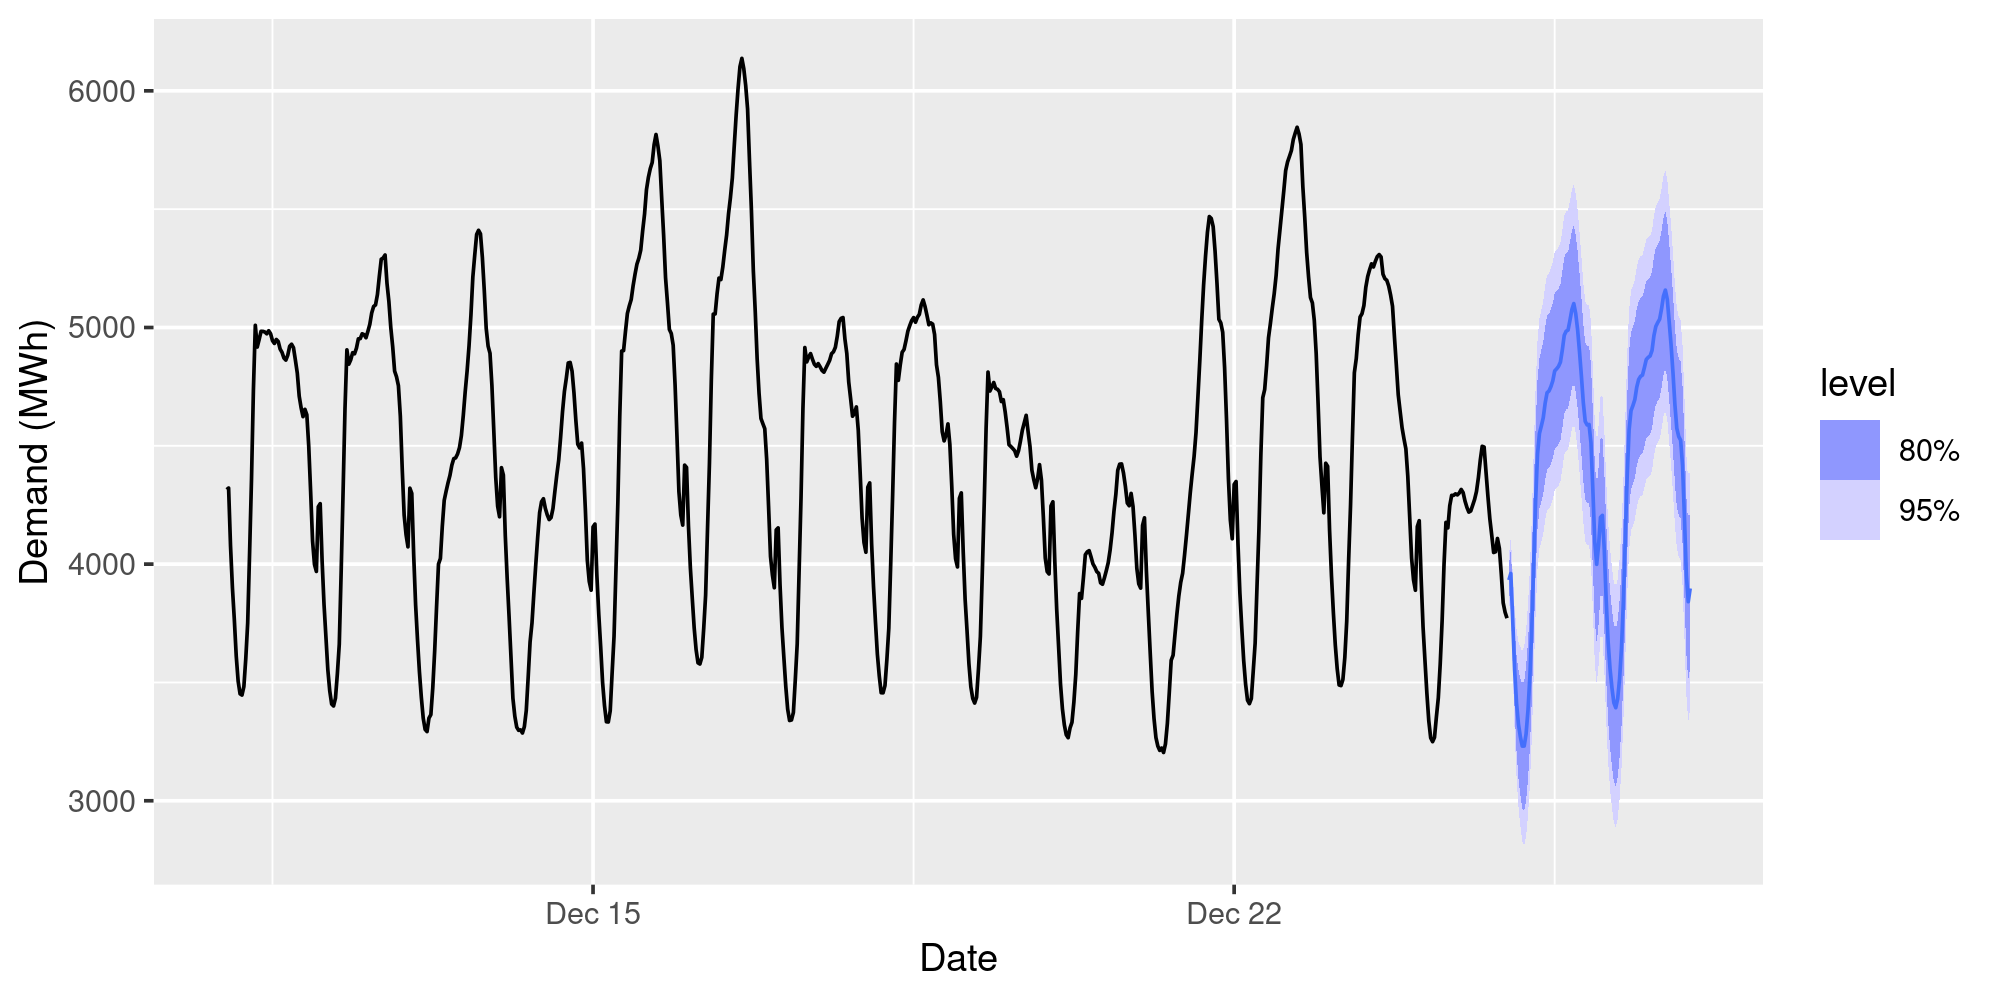

In [32]:
fc |>
  autoplot(elec_train_small) +
  labs(x = "Date", y = "Demand (MWh)")

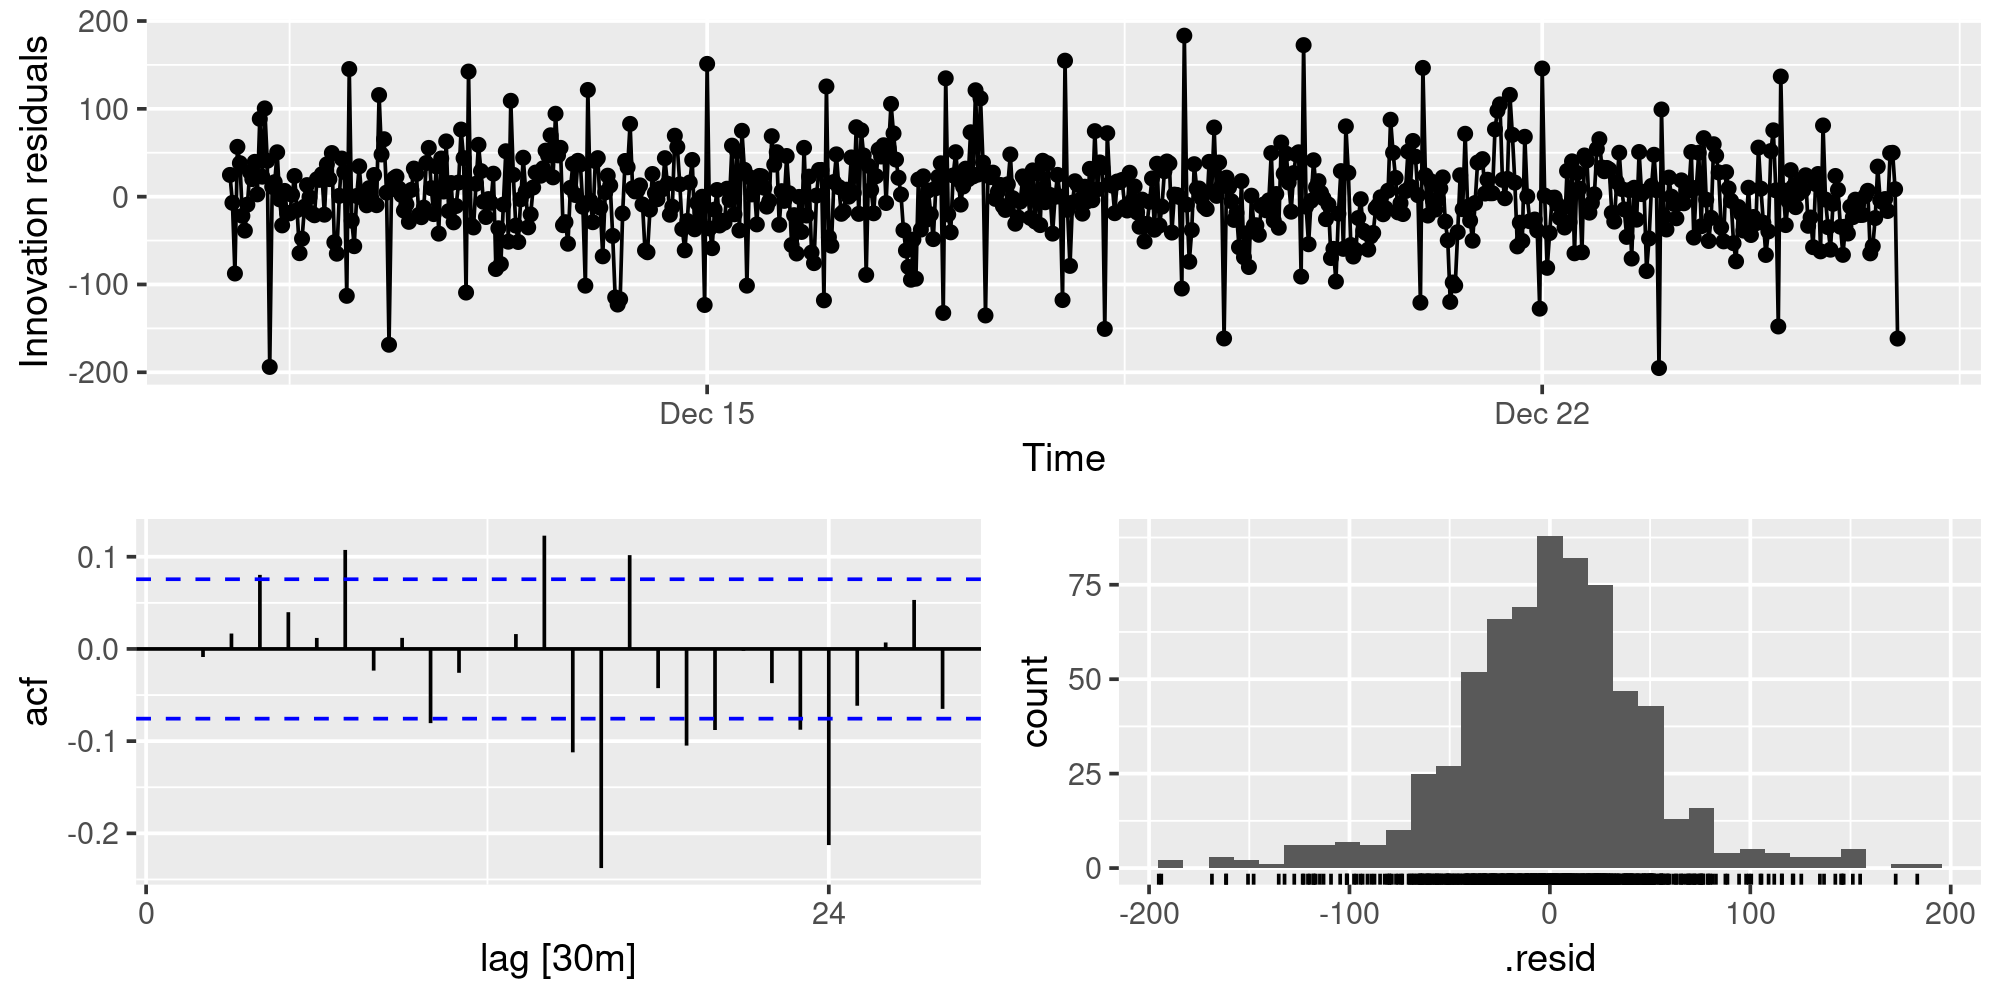

In [33]:
fit |> gg_tsresiduals()

## The Prophet model (revisited)

Prophet can be considered a nonlinear regression model, of the form 
$$
y_t = g(t) + s(t) + h(t) + \varepsilon_t,
$$
where 
- $g(t)$ describes a piecewise-linear trend (or “growth term”),
- $s(t)$ describes the various seasonal patterns, 
- $h(t)$ captures the holiday effects, and
- $\varepsilon_t$ is a white noise error term.

Estimation details:

- The seasonal component consists of Fourier terms of the relevant periods. By default, order 10 is used for annual seasonality and order 3 is used for weekly seasonality.
- Holiday effects are added as simple dummy variables.
- The knots (or changepoints) for the piecewise-linear trend are automatically selected if not explicitly specified. Optionally, a logistic function can be used to set an upper bound on the trend.
- The model is estimated using a Bayesian approach to allow for automatic selection of the changepoints and other model characteristics.

## Vector autoregressive models

One limitation of the models that we have considered so far is that they impose a unidirectional relationship — the forecast variable is influenced by the predictor variables, but not vice versa. 

However, there are many cases where the reverse should also be allowed for — where all variables affect each other.

A VAR model is a generalisation of the univariate autoregressive model for forecasting a vector of time series.

It comprises one equation per variable in the system. The right hand side of each equation includes a constant and lags of all of the variables in the system.

To keep it simple, we will consider a two variable VAR with one lag. 

We write a 2-dimensional VAR(1) model as 
\begin{align}
  y_{1,t} &= c_1+\phi _{11,1}y_{1,t-1}+\phi _{12,1}y_{2,t-1}+\varepsilon_{1,t} \tag{12.1}\\
  y_{2,t} &= c_2+\phi _{21,1}y_{1,t-1}+\phi _{22,1}y_{2,t-1}+\varepsilon_{2,t}, \tag{12.2}
\end{align}
where $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are white noise processes that may be contemporaneously correlated.

If the series are stationary, we forecast them by fitting a VAR to the data directly (known as a “VAR in levels”). 

If the series are non-stationary, we take differences of the data in order to make them stationary, then fit a VAR model (known as a “VAR in differences”). 

In both cases, the models are estimated equation by equation using the principle of least squares.

For each equation, the parameters are estimated by minimising the sum of squared $\varepsilon_{i,t}$ values.

## Forecasting for VAR models

Forecasts are generated from a VAR in a recursive manner. 

The VAR generates forecasts for each variable included in the system.

For example, the one-step-ahead forecasts are generated by
\begin{align*}
  \hat y_{1,T+1|T} &=\hat{c}_1+\hat\phi_{11,1}y_{1,T}+\hat\phi_{12,1}y_{2,T} \\
  \hat y_{2,T+1|T} &=\hat{c}_2+\hat\phi _{21,1}y_{1,T}+\hat\phi_{22,1}y_{2,T}.
\end{align*}

For $h=2$,
\begin{align*}
  \hat y_{1,T+2|T} &=\hat{c}_1+\hat\phi_{11,1}\hat y_{1,T+1|T}+\hat\phi_{12,1}\hat y_{2,T+1|T}\\
  \hat y_{2,T+2|T}&=\hat{c}_2+\hat\phi_{21,1}\hat y_{1,T+1|T}+\hat\phi_{22,1}\hat y_{2,T+1|T}.
\end{align*}

The process can be iterated in this manner for all future time periods.

## Model selection

There are two decisions one has to make when using a VAR to forecast, namely how many variables (denoted by $K$) and how many lags (denoted by $p$) should be included in the system. 

The number of coefficients to be estimated in a VAR is equal to $K+pK^2$ (or $1+pK$ per equation). 

For example, for a VAR with $K=5$ variables and $p=3$ lags, there are 16 coefficients per equation, giving a total of 80 coefficients to be estimated. 

The more coefficients that need to be estimated, the larger the estimation error entering the forecast.

In practice, it is usual to keep $K$ small and include only variables that are correlated with each other, and therefore useful in forecasting each other.

Information criteria are commonly used to select the number of lags to be included. 

Care should be taken when using the AICc as it tends to choose large numbers of lags; instead, for VAR models, we often use the BIC instead. 

A more sophisticated version of the model is a “sparse VAR” (where many coefficients are set to zero); another approach is to use “shrinkage estimation” (where coefficients are smaller).

## Pros and Cons of VARs

A criticism that VARs face is that they are atheoretical; that is, they are not built on some economic theory that imposes a theoretical structure on the equations. 

Every variable is assumed to influence every other variable in the system, which makes a direct interpretation of the estimated coefficients difficult. 

Despite this, VARs are useful in several contexts:

1. forecasting a collection of related variables where no explicit interpretation is required;
2. testing whether one variable is useful in forecasting another (the basis of Granger causality tests);
3. impulse response analysis, where the response of one variable to a sudden but temporary change in another variable is analysed;
4. forecast error variance decomposition, where the proportion of the forecast variance of each variable is attributed to the effects of the other variables.


## Example: A VAR model for forecasting US consumption

In [34]:
us_change |> select(Quarter, Consumption, Income)

Quarter Consumption Income    
1   1970 Q1  0.6185664   1.0448013
2   1970 Q2  0.4519840   1.2256472
3   1970 Q3  0.8728718   1.5851538
4   1970 Q4 -0.2718479  -0.2395449
5   1971 Q1  1.9013450   1.9759249
⋮   ⋮       ⋮           ⋮         
194 2018 Q2 0.9831119   0.6618253 
195 2018 Q3 0.8531814   0.8062713 
196 2018 Q4 0.3565120   0.6951422 
197 2019 Q1 0.2828855   1.1007530 
198 2019 Q2 1.1135167   0.5933995

In [35]:
fit <- us_change |>
  model(
    aicc = VAR(vars(Consumption, Income)),
    bic = VAR(vars(Consumption, Income), ic = "bic")
  )
fit

aicc             bic             
1 <VAR(5) w/ mean> <VAR(1) w/ mean>

In [36]:
fit |> select(bic) |> tidy()

.model term               .response   estimate   std.error  statistic
11 bic    lag(Consumption,1) Consumption  0.2652970 0.07267395  3.650510
12 bic    lag(Income,1)      Consumption  0.1129687 0.05144272  2.196010
13 bic    constant           Consumption  0.4642949 0.06766649  6.861519
21 bic    lag(Consumption,1) Income       0.4919328 0.10312151  4.770419
22 bic    lag(Income,1)      Income      -0.2575641 0.07299522 -3.528506
23 bic    constant           Income       0.5499630 0.09601612  5.727819
   p.value     
11 3.364941e-04
12 2.927685e-02
13 8.922728e-11
21 3.606707e-06
22 5.217570e-04
23 3.828222e-08

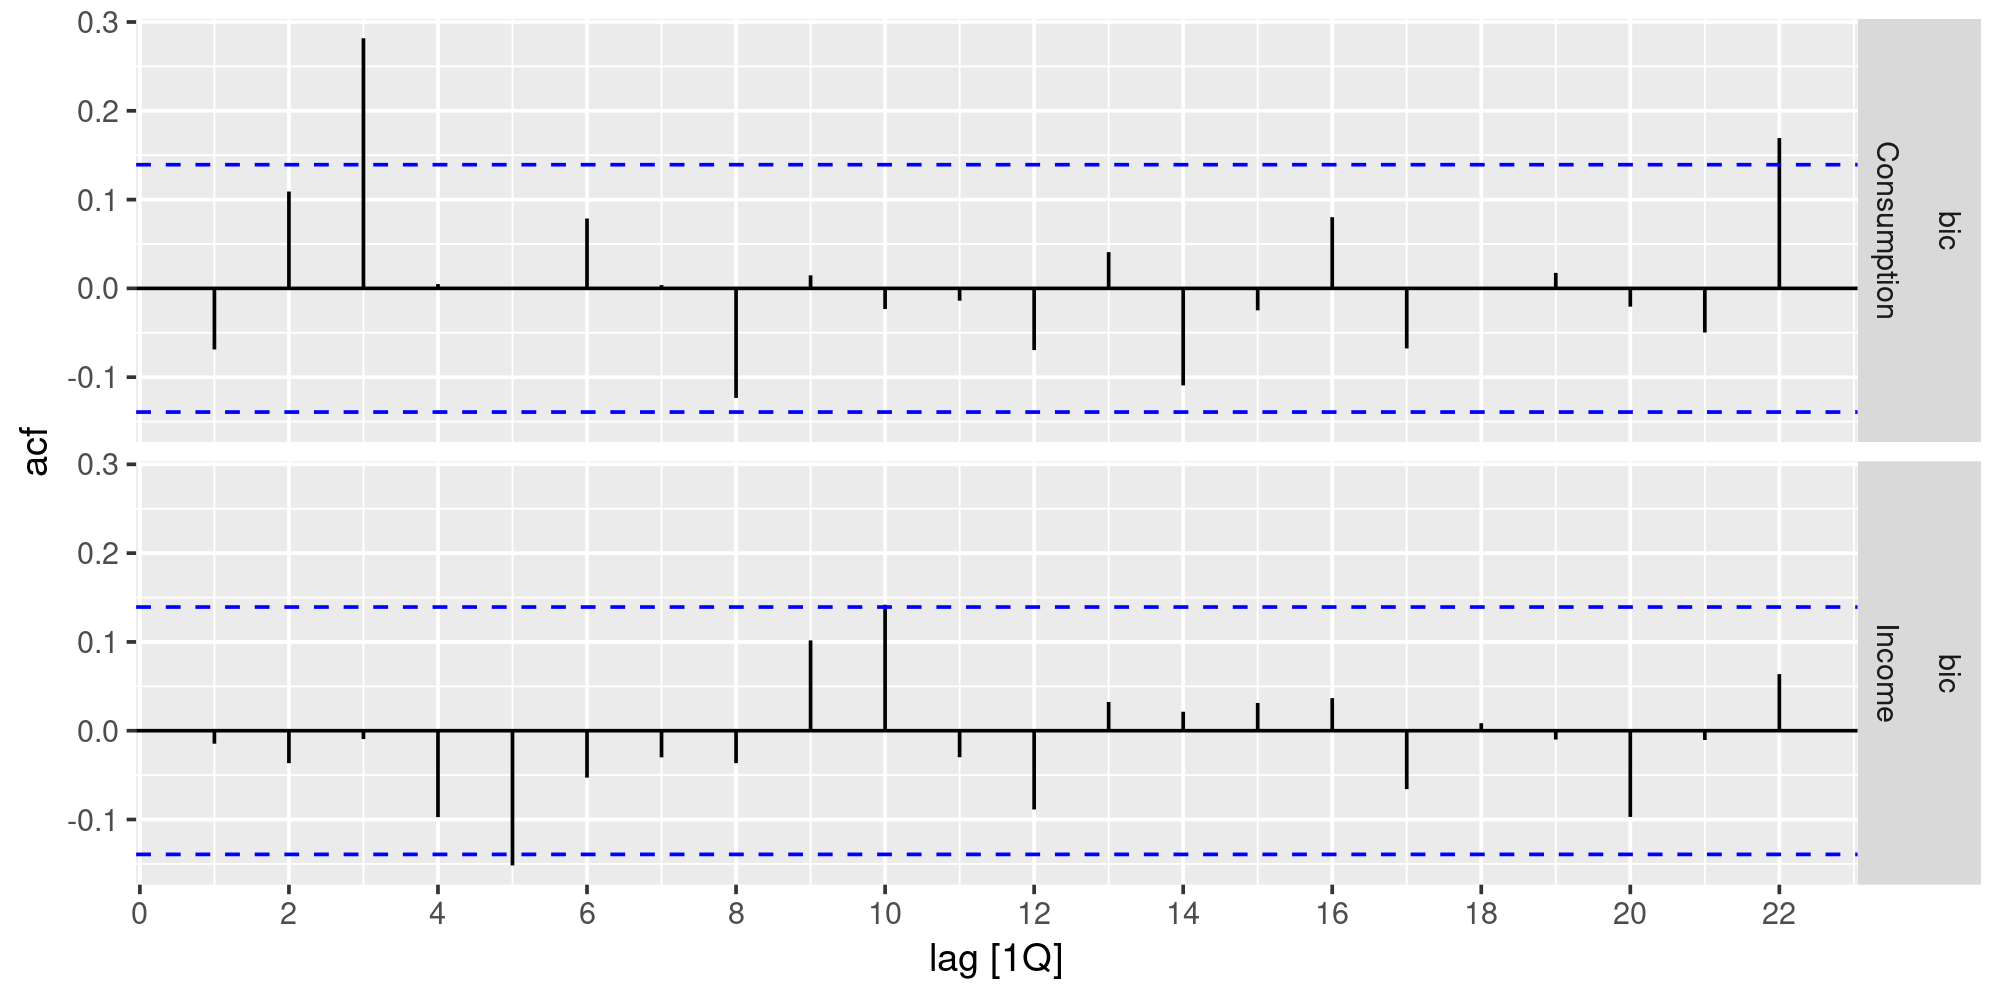

In [37]:
fit |> select(bic) |>
  augment() |>
  ACF(.innov) |>
  autoplot()

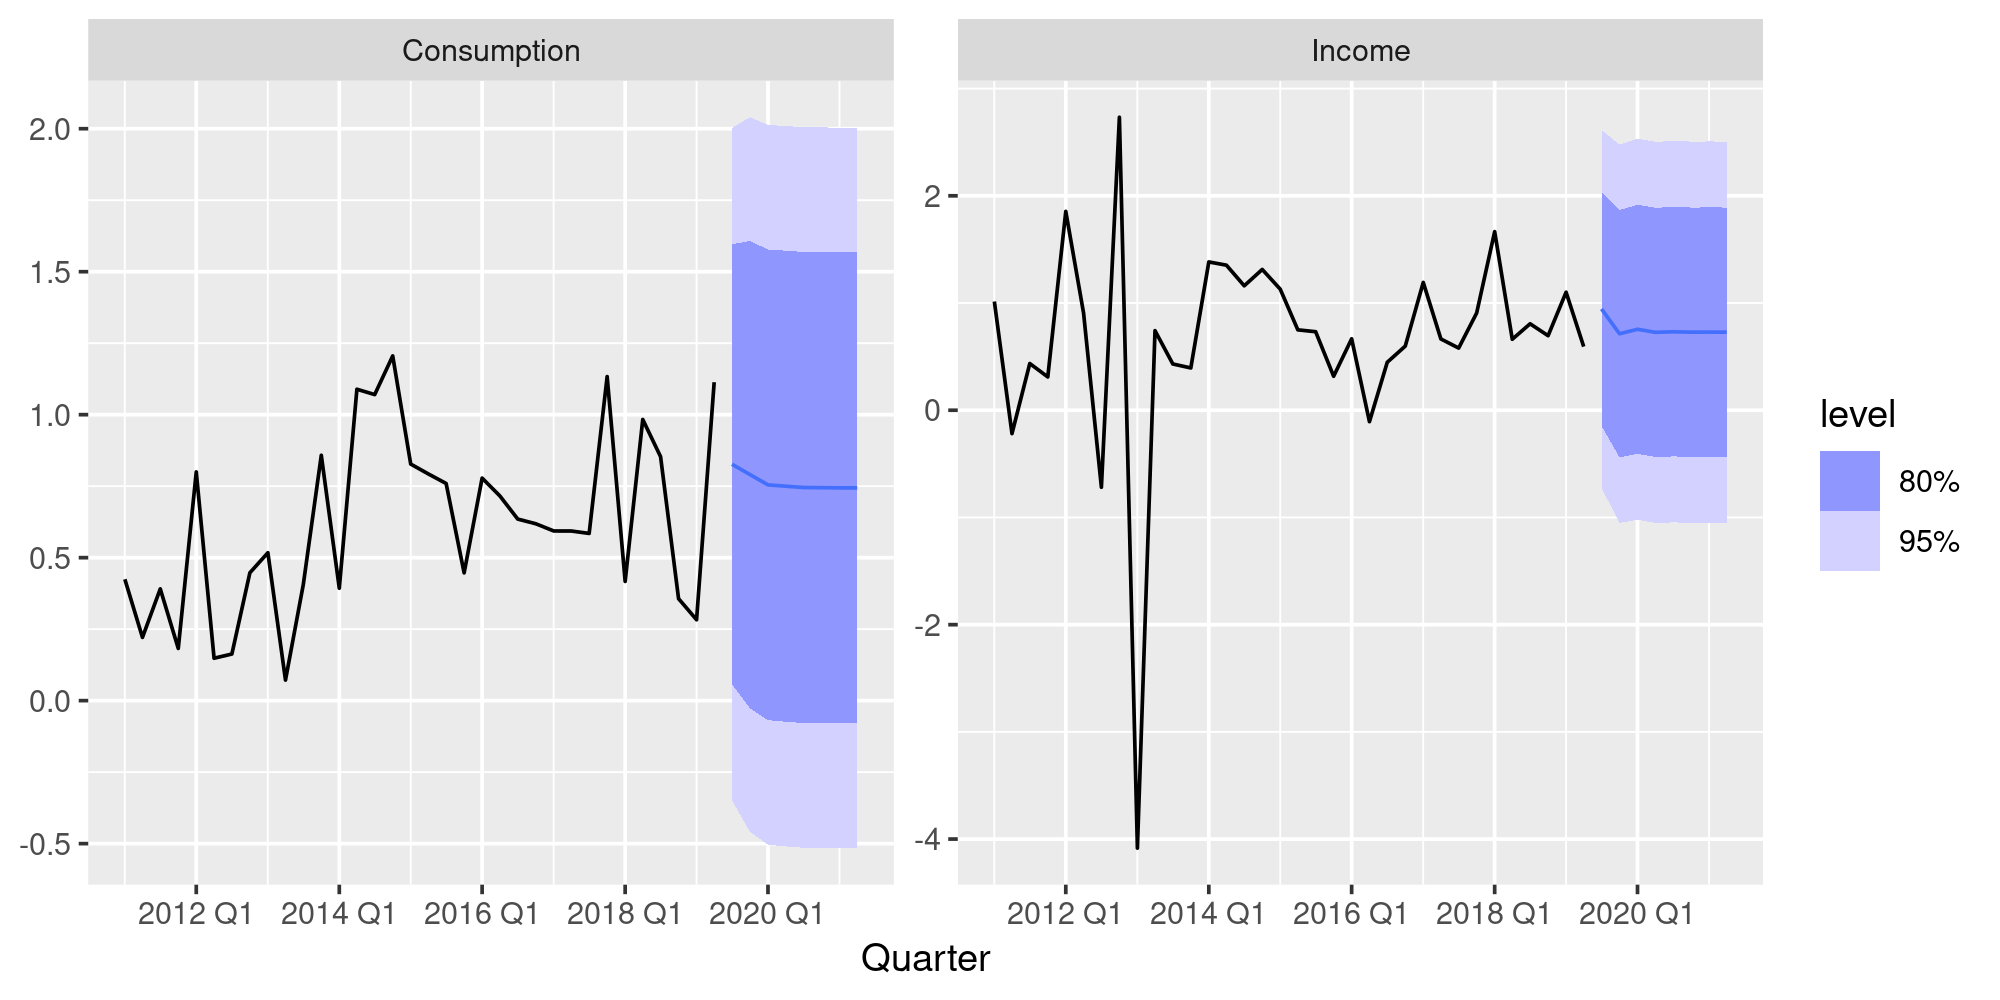

In [38]:
fit |>
  select(bic) |>
  forecast() |>
  autoplot(us_change |> filter(year(Quarter) > 2010))

## Neural network models

Artificial neural networks are forecasting methods that are based on simple mathematical models of the brain. They allow complex nonlinear relationships between the response variable and its predictors.

## Neural network architecture

A neural network can be thought of as a network of “neurons” which are organised in layers. The predictors (or inputs) form the bottom layer, and the forecasts (or outputs) form the top layer. There may also be intermediate layers containing “hidden neurons”.

The simplest networks contain no hidden layers and are equivalent to linear regressions. 

The following example shows the neural network version of a linear regression with four predictors. 

<p align="center">
  <img src="img/nnet1-1.png" alt="NNet" width="500"/>
</p>

The coefficients attached to these predictors are called “weights”. The forecasts are obtained by a linear combination of the inputs. 

The weights are selected in the neural network framework using a “learning algorithm” that minimises a “cost function” such as the MSE.

Of course, in this simple example, we can use linear regression which is a much more efficient method of training the model.


Once we add an intermediate layer with hidden neurons, the neural network becomes non-linear.

<p align="center">
  <img src="img/nnet2-1.png" alt="NNet" width="600"/>
</p>

This is known as a multilayer feed-forward network, where each layer of nodes receives inputs from the previous layers. 

The outputs of the nodes in one layer are inputs to the next layer. The inputs to each node are combined using a weighted linear combination. 

The result is then modified by a nonlinear function before being output.

For example, the inputs into each hidden neuron in the previous network are combined linearly to give 
$$
z_j = b_j + \sum_{i=1}^4 w_{i,j} x_i.
$$

In the hidden layer, this is then modified using a nonlinear function such as a sigmoid, 
 $$
 s(z) = \frac{1}{1+e^{-z}},
 $$
 to give the input for the next layer. 
 
 This tends to reduce the effect of extreme input values, thus making the network somewhat robust to outliers. 

 The parameters $b_1,b_2,b_3$ and $w_{1,1},\ldots,w_{4,3}$ are “learned” (or estimated) from the data. 
 
 The values of the weights are often restricted to prevent them from becoming too large. 
 
 The parameter that restricts the weights is known as the “decay parameter”, and is often set to be equal to 0.1.

The weights take random values to begin with, and these are then updated using the observed data. Consequently, there is an element of randomness in the predictions produced by a neural network.
 
Therefore, the network is usually trained several times using different random starting points, and the results are averaged.

The number of hidden layers, and the number of nodes in each hidden layer, must be specified in advance.

Usually, these would be selected using cross-validation.

## Neural network autoregression (NNAR)

With time series data, lagged values of the time series can be used as inputs to a neural network, just as we used lagged values in a linear autoregression model. 

We call this a neural network autoregression or NNAR model.

Today, we only consider feed-forward networks with one hidden layer, and we use the notation $\text{NNAR}(p,k)$ to indicate there are $p$ lagged inputs and $k$ nodes in the hidden layer. 

For example, a $\text{NNAR}(9,5)$ model is a neural network with the last nine observations $(y_{t−1},y_{t−2},\ldots,y_{t−9})$ used as inputs for forecasting the output $y_t$, and with five neurons in the hidden layer. 

A $\text{NNAR}(p,0)$ model is equivalent to an $\text{ARIMA}(p,0,0)$ model, but without the restrictions on the parameters to ensure stationarity.

## Handling seasonal data

With seasonal data, it is useful to also add the last observed values from the same season as inputs.

For example, an $\text{NNAR}(3,1,2)_{12}$ model has inputs $(y_{t−1},y_{t−2},y_{t-3}, y_{t−12})$, and two neurons in the hidden layer. 

More generally, an $\text{NNAR}(p,P,k)_{m}$ model has inputs $(y_{t−1},y_{t−2},\ldots,y_{t−p},y_{t−m},y_{t−2m},\ldots,y_{t−Pm})$ and $k$ neurons in the hidden layer. 


A $\text{NNAR}(p,P,0)_m$ model is equivalent to an $\text{ARIMA}(p,0,0)(P,0,0)_m$ model but without the restrictions on the parameters that ensure stationarity.

## NNAR in R

The `NNETAR()` function fits an $\text{NNAR}(p,P,k)_m$ model. 

If the values of $p$ and $P$ are not specified, they are selected automatically.

For non-seasonal time series, the default is the optimal number of lags (according to the AIC) for a linear AR(p) model.

For seasonal time series, the default values are $P=1$ and $p$ is chosen from the optimal linear model fitted to the seasonally adjusted data.

If $k$ is not specified, it is set to $k=(p+P+1)/2$ (rounded to the nearest integer).

## Forecasting with NNAR

When it comes to forecasting, the network is applied iteratively. 

For forecasting one step ahead, we simply use the available historical inputs. 

For forecasting two steps ahead, we use the one-step forecast as an input, along with the historical data. 

This process proceeds until we have computed all the required forecasts.

## Prediction intervals with NNAR

Unlike most of the methods considered in this book, neural networks are not based on a well-defined stochastic model, and so it is not straightforward to derive prediction intervals for the resultant forecasts. 

However, we can still compute prediction intervals using simulation where future sample paths are generated using bootstrapped residuals

## Example: Sunspots

The surface of the sun contains magnetic regions that appear as dark spots. These affect the propagation of radio waves, and so telecommunication companies like to predict sunspot activity in order to plan for any future difficulties.

Sunspots follow a cycle of length between 9 and 14 years. 

In [39]:
sunspots <- sunspot.year |> as_tsibble()

sunspots

index value
1   1700   5   
2   1701  11   
3   1702  16   
4   1703  23   
5   1704  36   
⋮   ⋮     ⋮    
285 1984   45.9
286 1985   17.9
287 1986   13.4
288 1987   29.2
289 1988  100.2

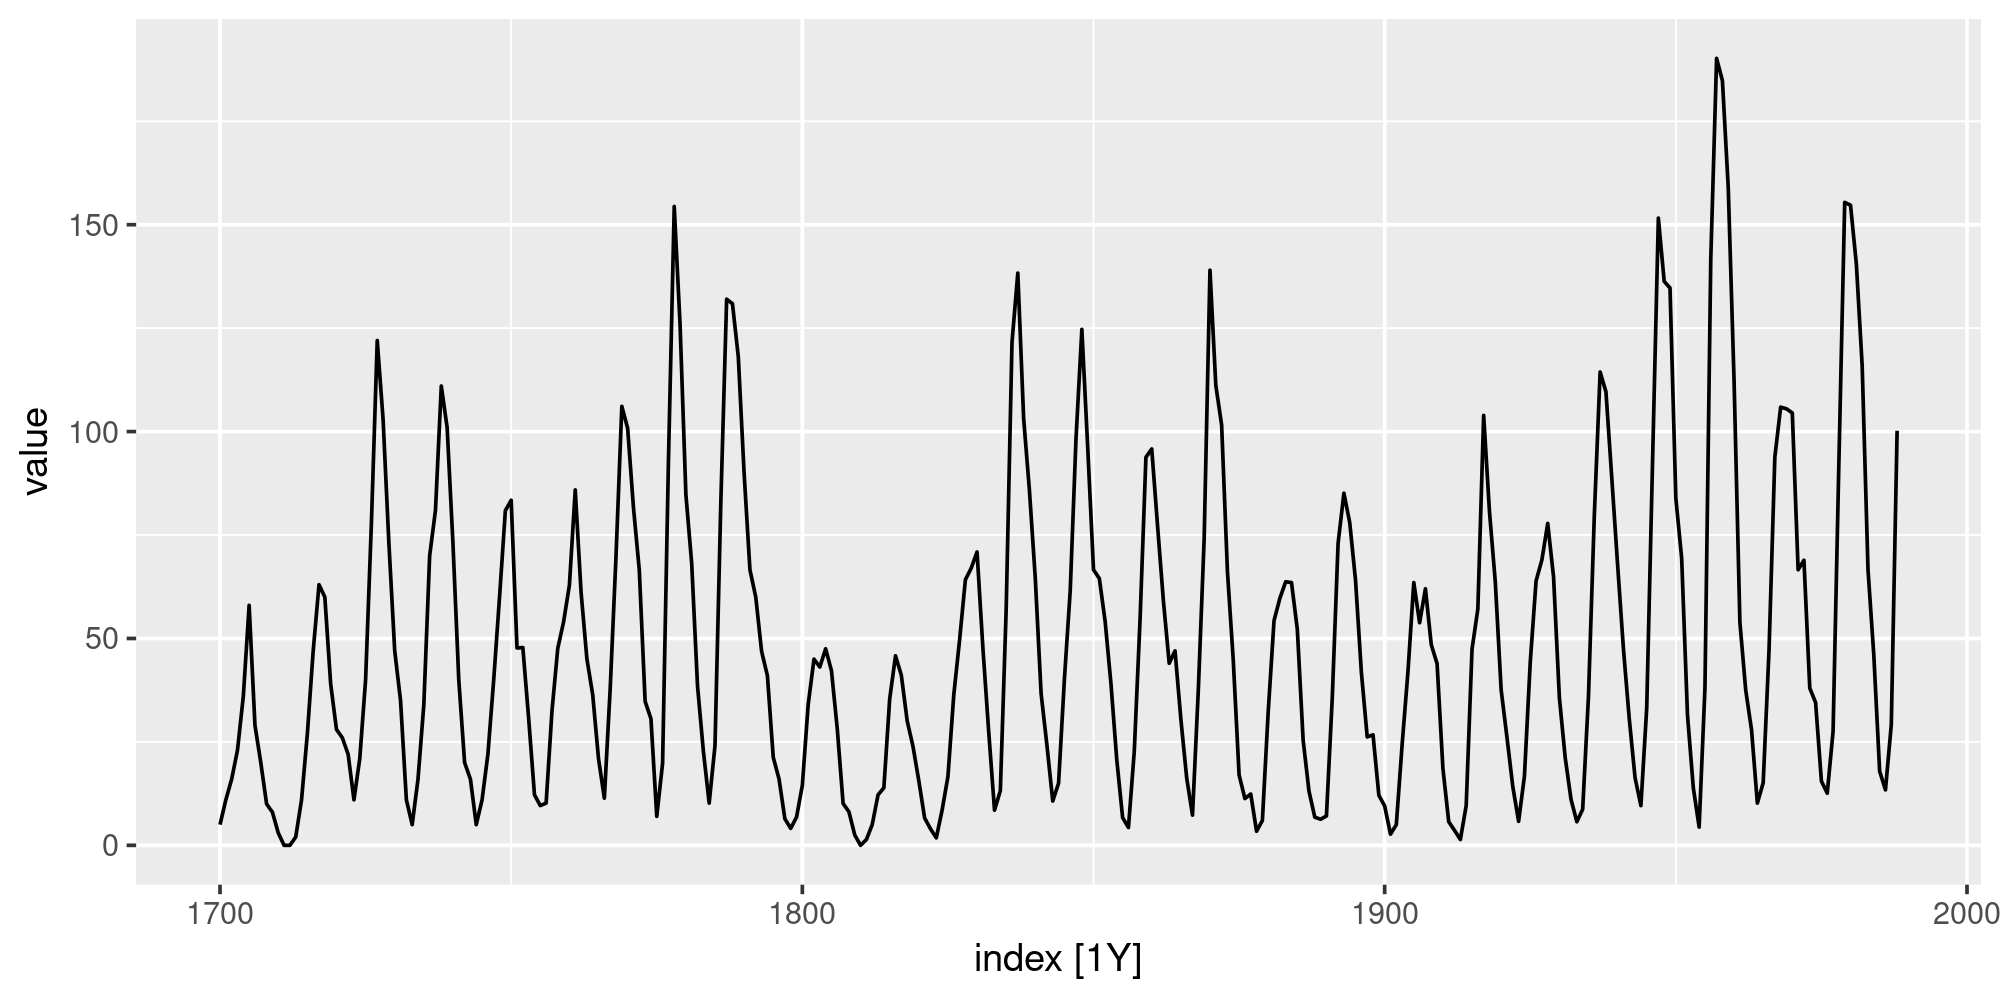

In [40]:
sunspots |> autoplot(value)

In [41]:
fit <- sunspots |>
    model(NNETAR(sqrt(value)))

fit

NNETAR(sqrt(value))
1 <NNAR(9,5)>

We have used a square root transformation to ensure the forecasts stay positive.

Let's compute forecasts for the next 30 years. 

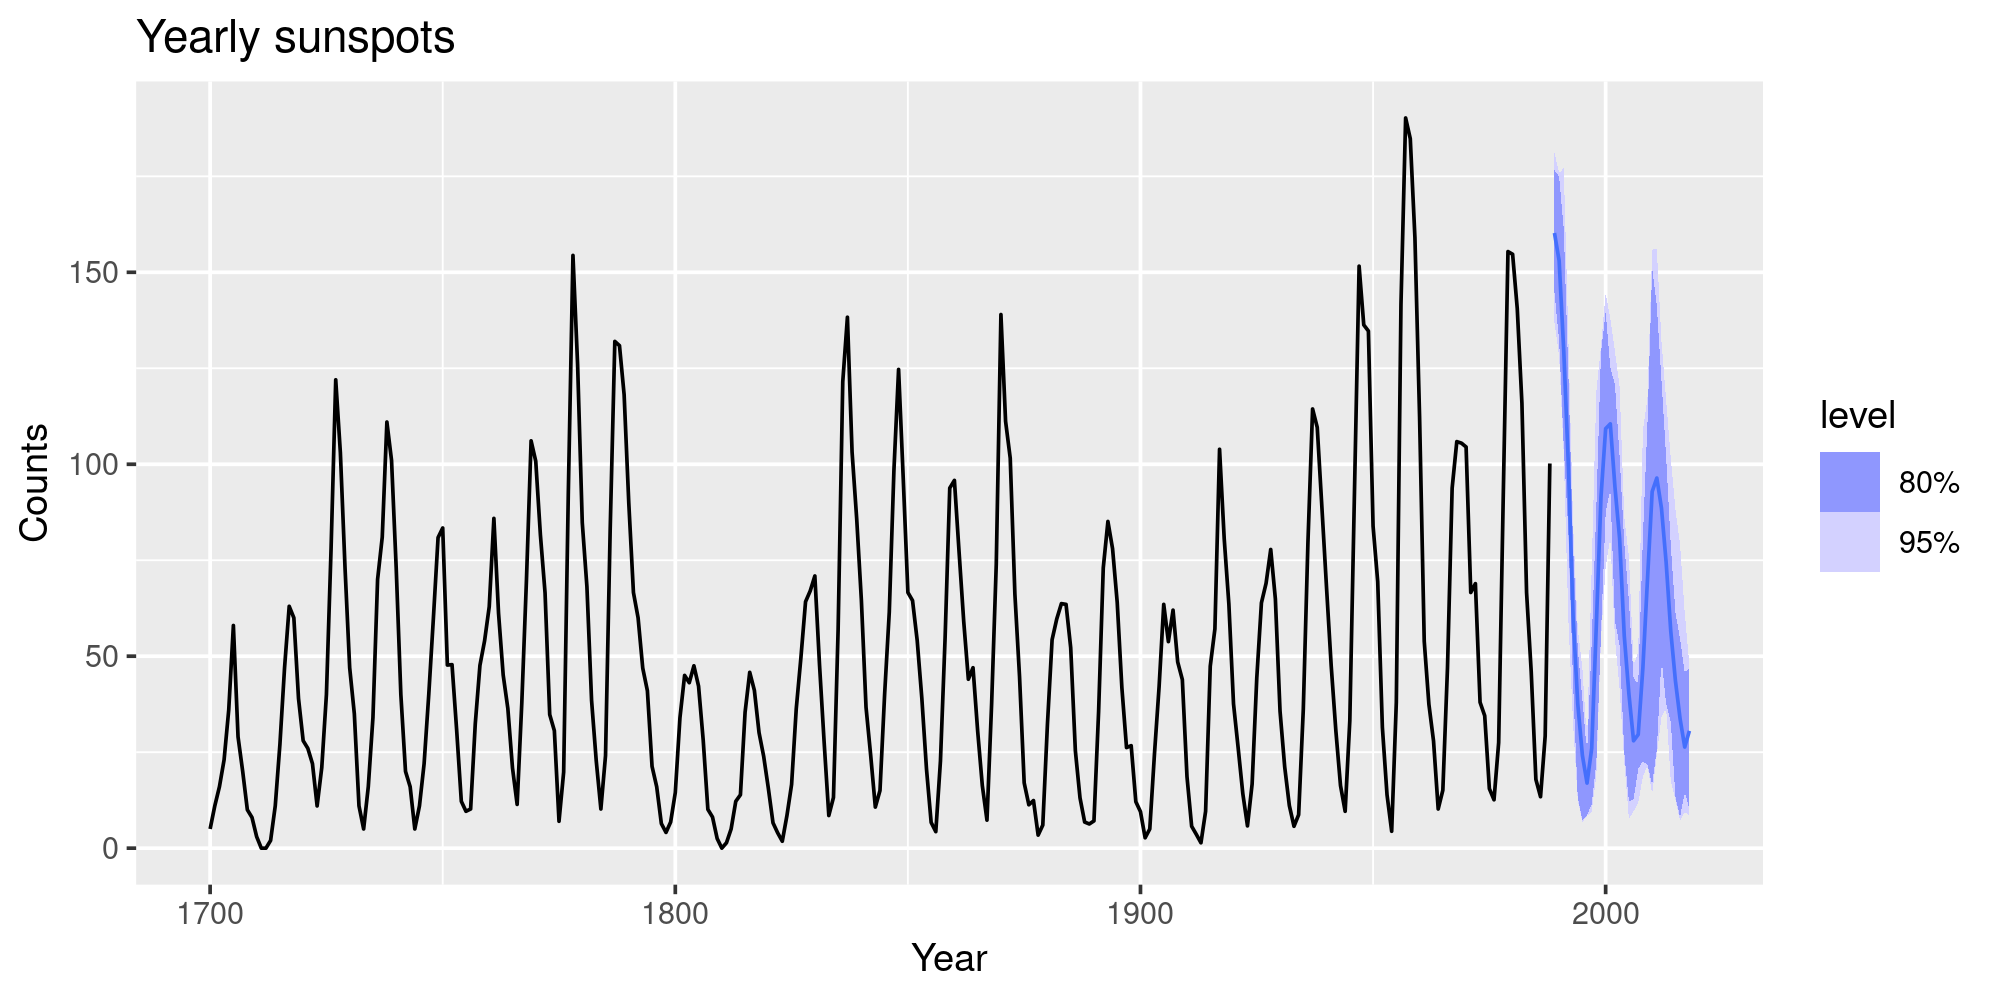

In [42]:
fit |>
    forecast(h = 30, times=10) |>
    autoplot(sunspots) +
    labs(x = "Year", y = "Counts", title = "Yearly sunspots")

Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 9 rows containing non-finite outside the scale range (`stat_bin()`).”


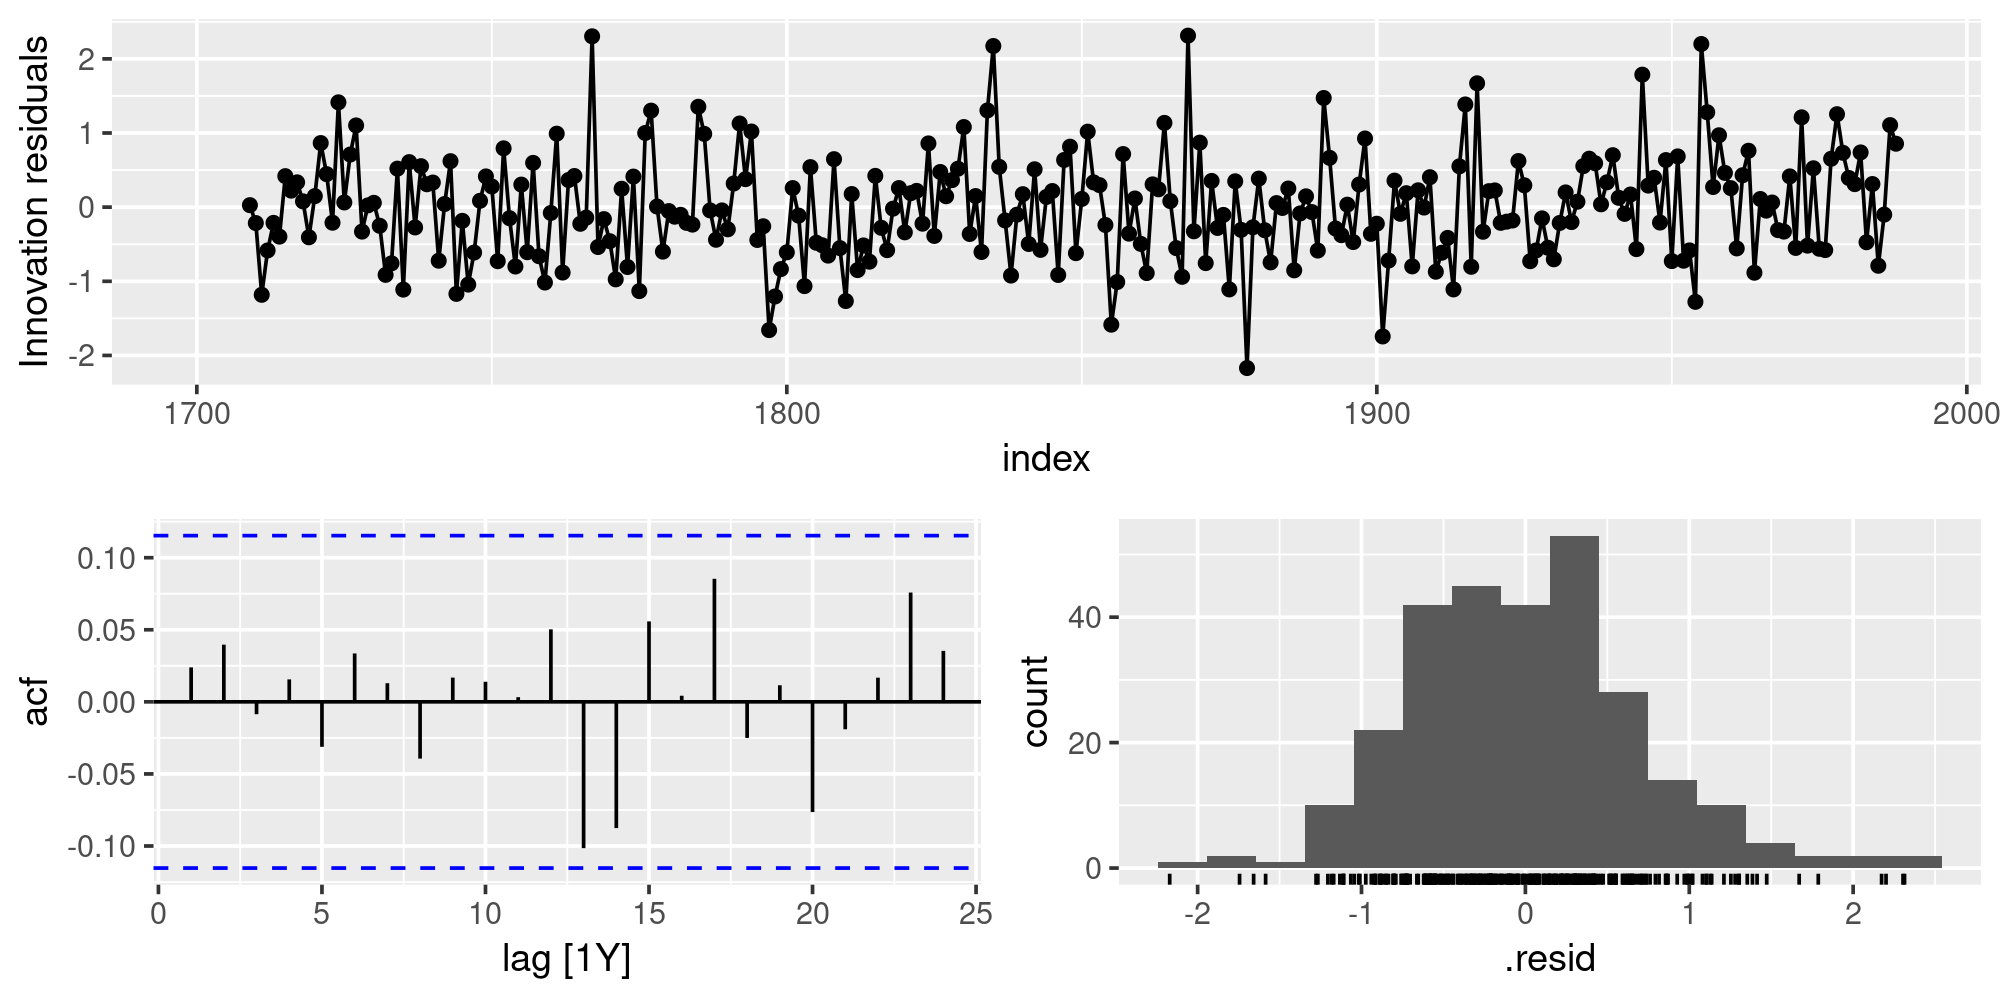

In [43]:
fit |> gg_tsresiduals()

The cyclicity in the data has been modelled well. 

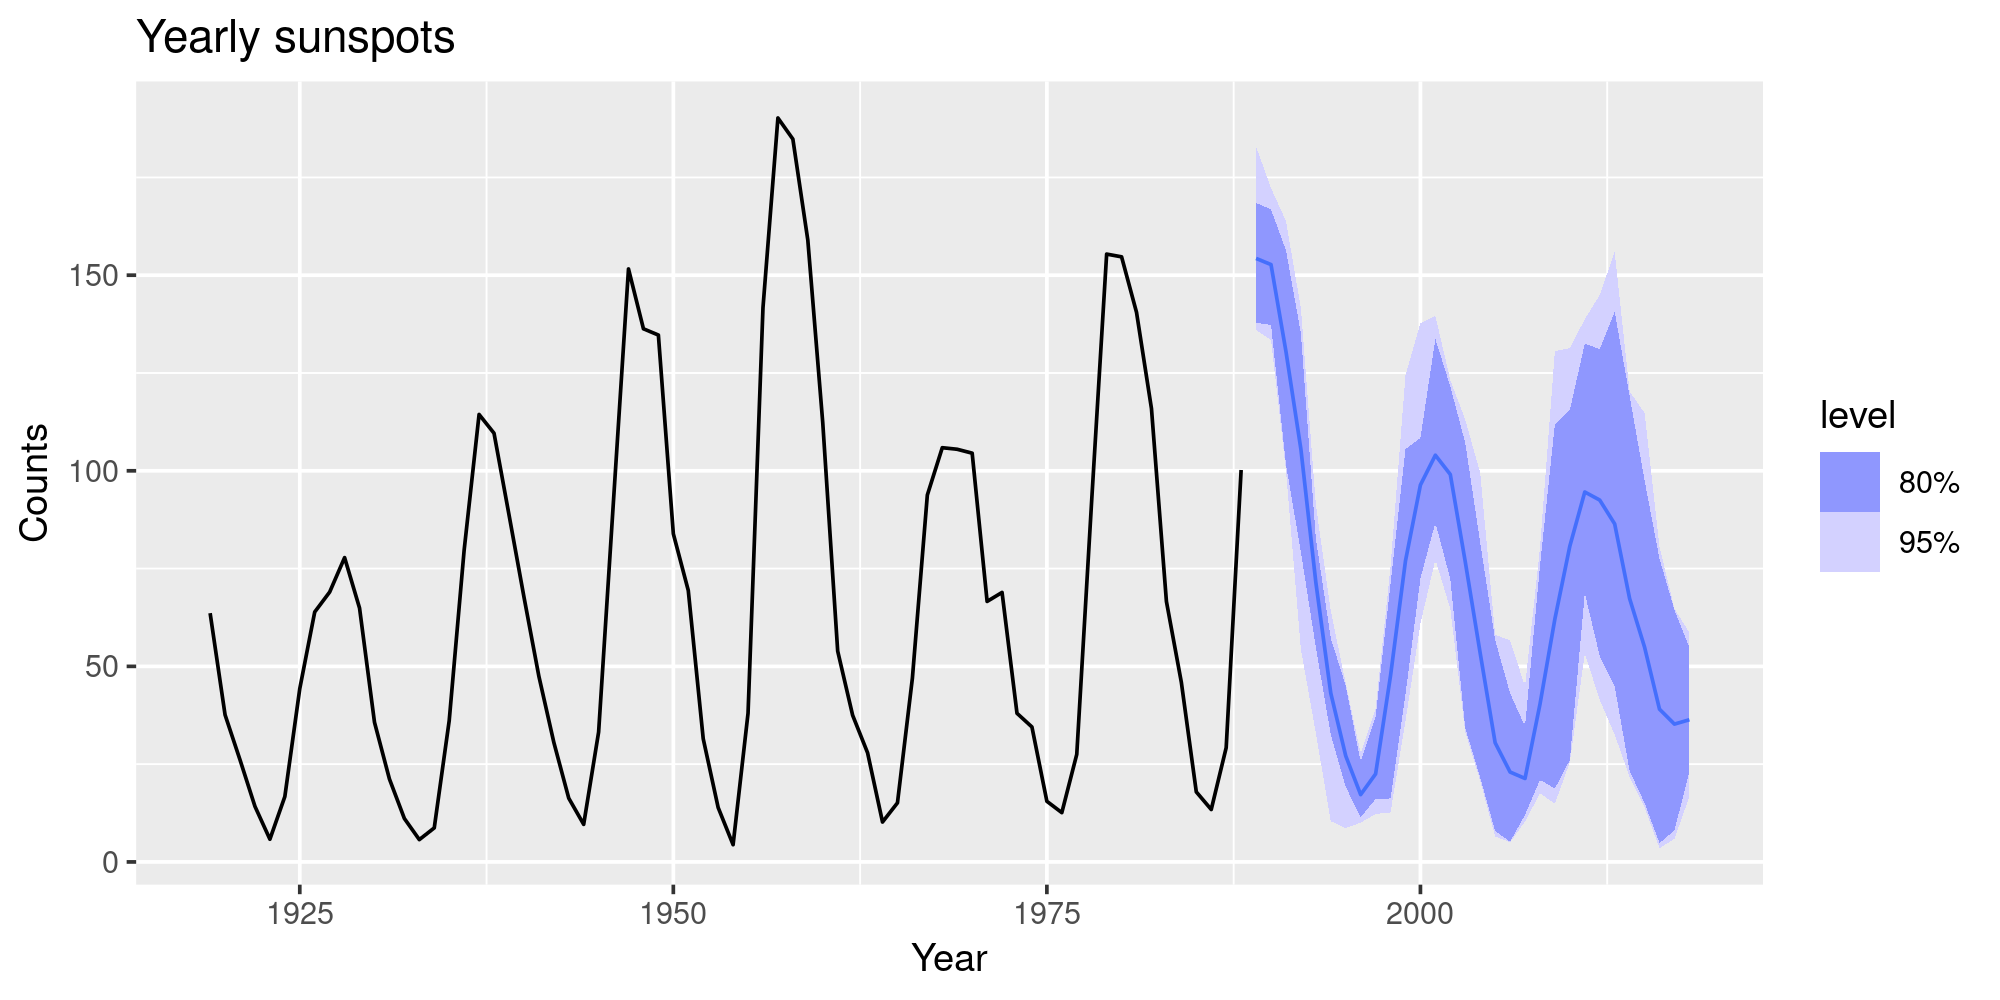

In [44]:
fit |>
    forecast(h = 30, times=10) |>
    autoplot(tail(sunspots,70)) +
    labs(x = "Year", y = "Counts", title = "Yearly sunspots")

We can also see the asymmetry of the cycles has been captured by the model, where the increasing part of the cycle is steeper than the decreasing part of the cycle. 

This is one difference between a NNAR model and a linear AR model — while linear AR models can model cyclicity, the modelled cycles are always symmetric.

## Bootstrapping and bagging

## Bootstrapping time series

Previously, we bootstrap the residuals of a time series in order to simulate future values of a series using a model.

More generally, we can generate new time series that are similar to our observed series, using another type of bootstrap.

First, the time series is transformed if necessary, and then decomposed into trend, seasonal and remainder components using STL.

Then we obtain shuffled versions of the remainder component to get bootstrapped remainder series.

Because there may be autocorrelation present in an STL remainder series, we use a “blocked bootstrap”, where contiguous sections of the time series are selected at random and joined together.

These bootstrapped remainder series are added to the trend and seasonal components, and the transformation is reversed to give variations on the original time series.

## Example: cement production

Consider the quarterly cement production in Australia from 1988 Q1 to 2010 Q2. 

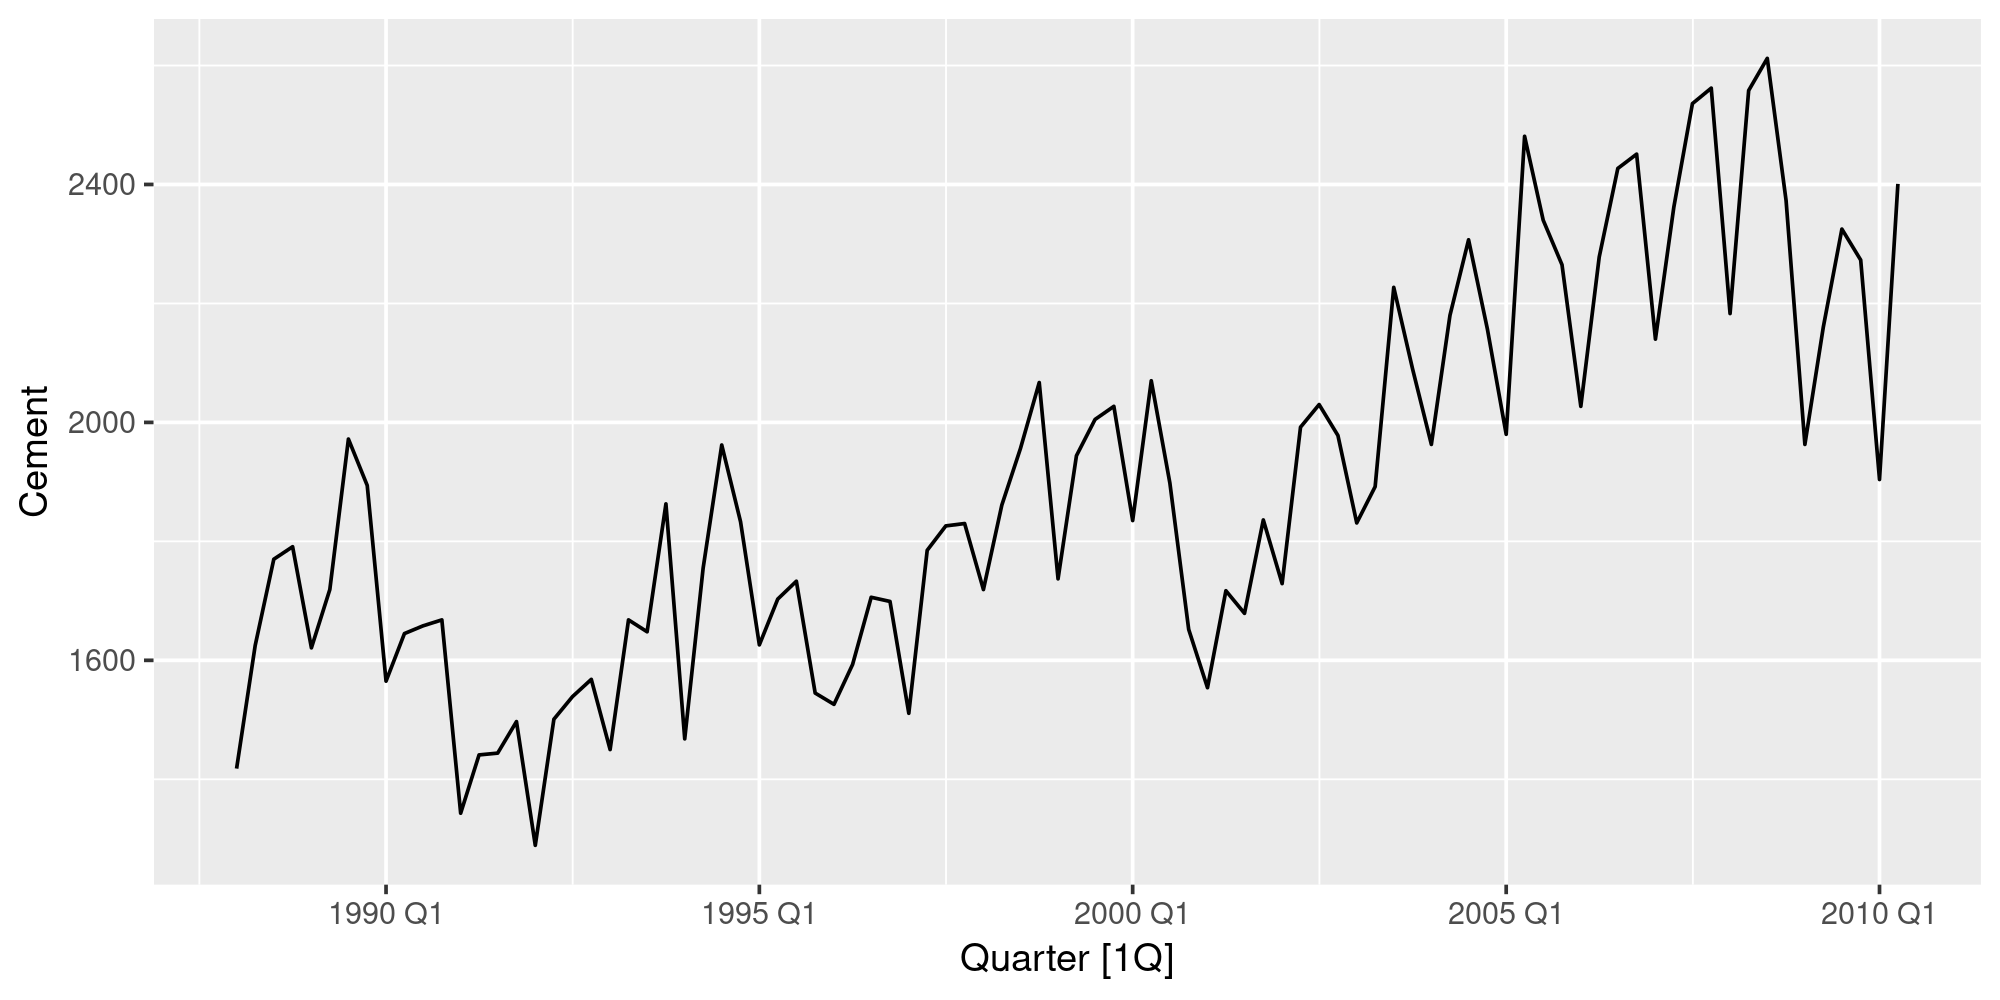

In [45]:
cement <- aus_production |>
    filter(year(Quarter) >= 1988) |>
    select(Quarter, Cement)

cement |> autoplot(Cement)

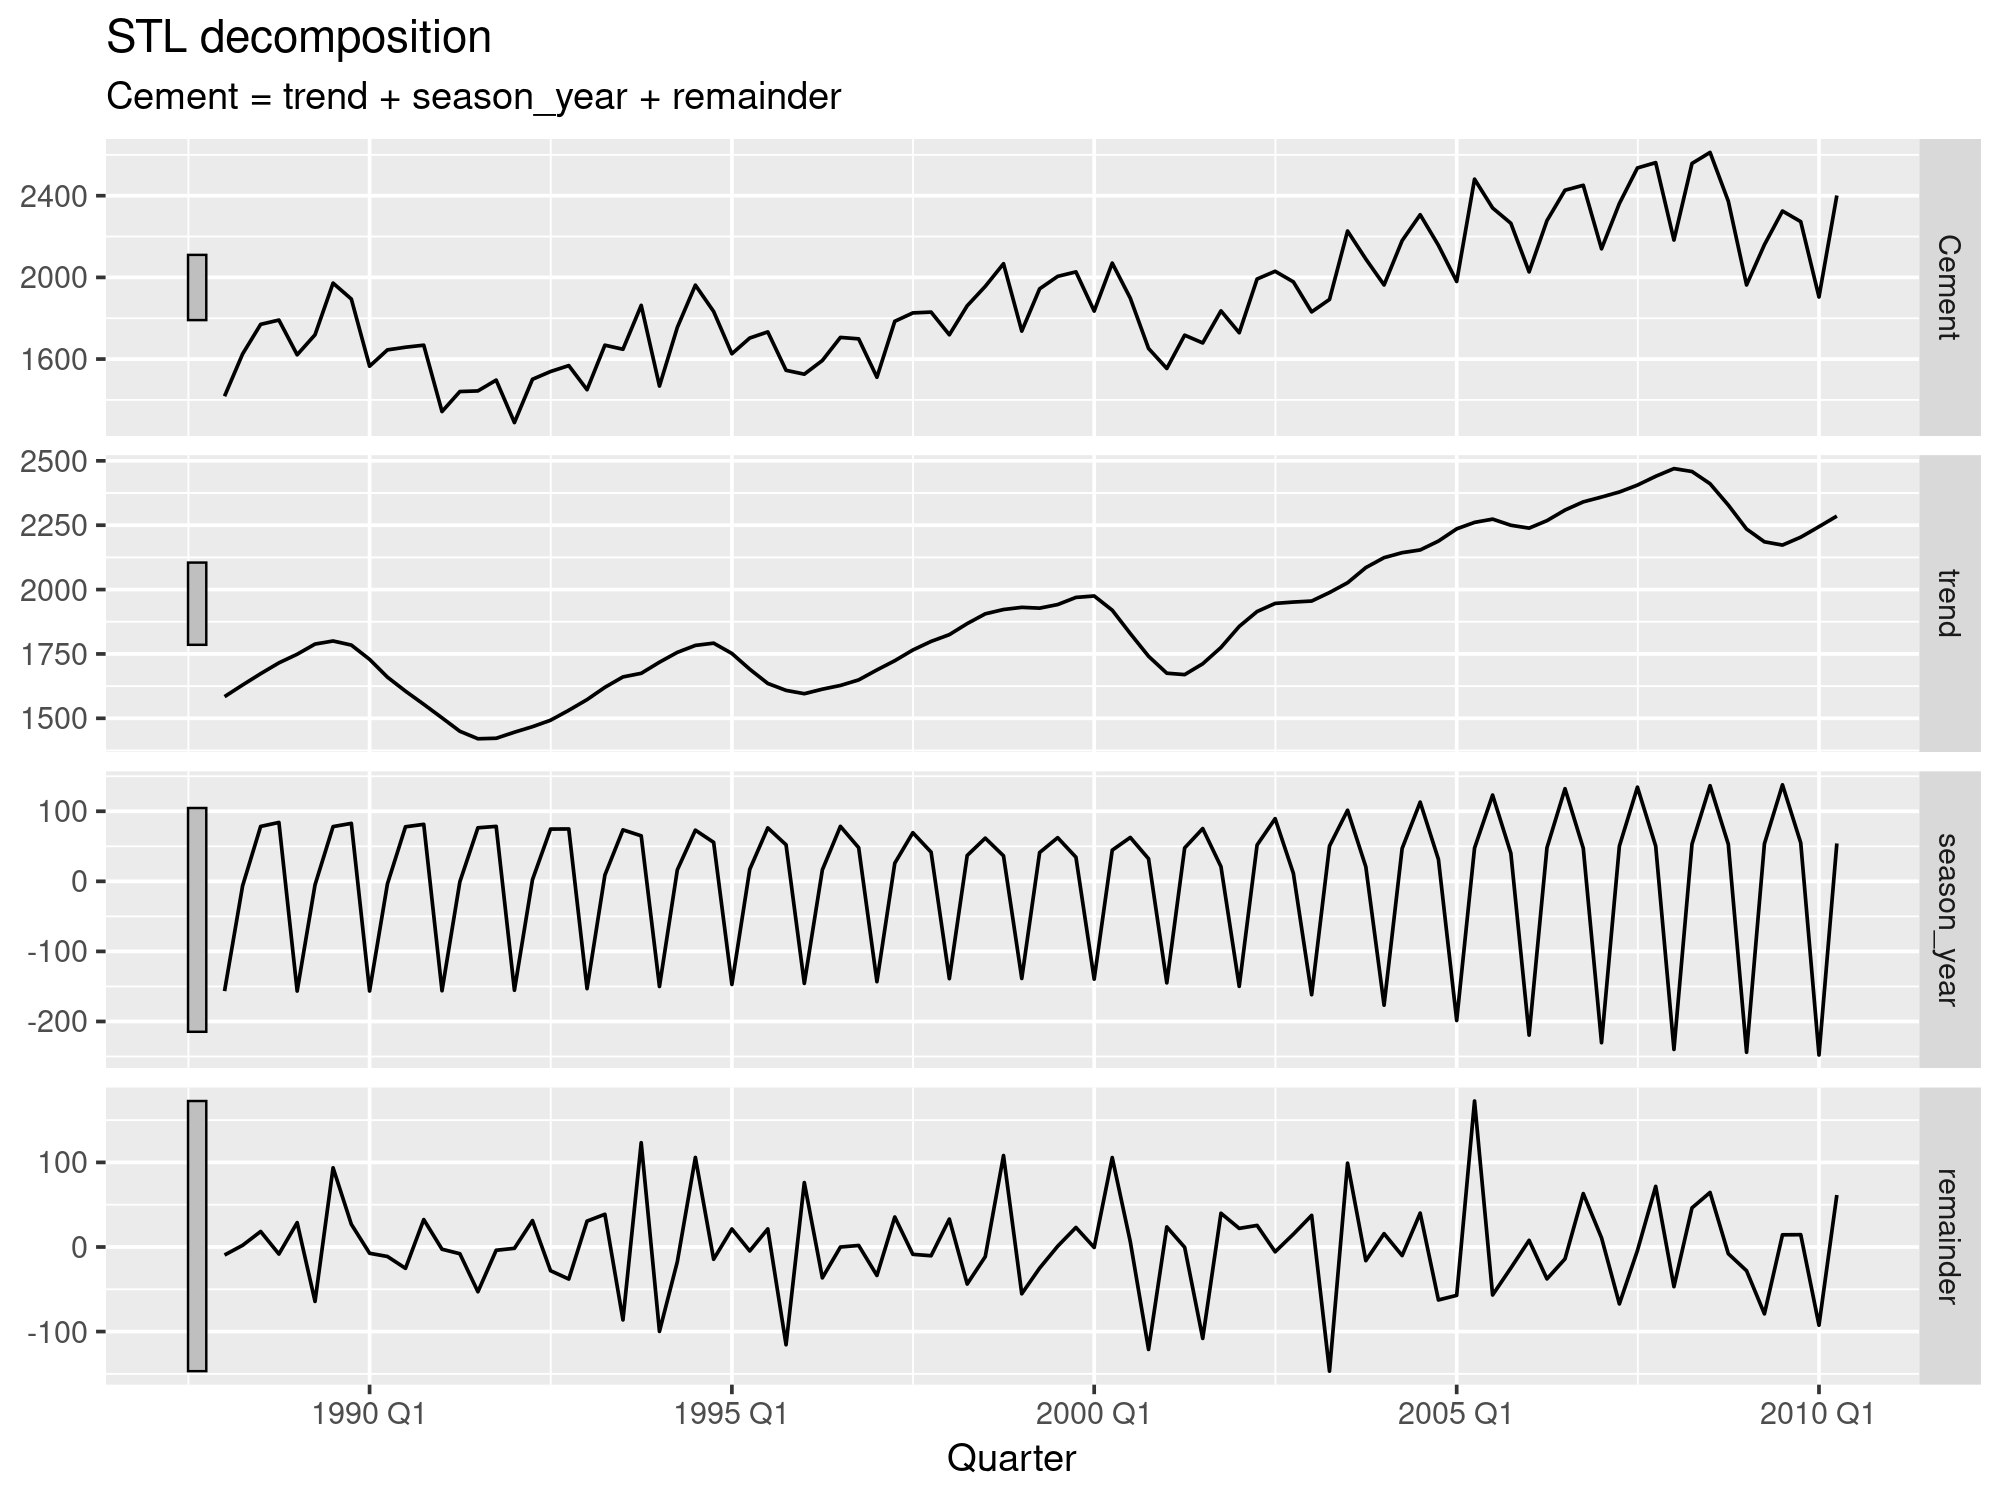

In [46]:
cement_stl <- cement |>
    model(stl = STL(Cement))

options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 250)

cement_stl |>
    components() |>
    autoplot()

options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 250)

First we check that the decomposition has adequately captured the trend and seasonality, and that there is no obvious remaining signal in the remainder series.

Now we can generate several bootstrapped versions of the data. 

Usually, `generate()` produces simulations of the future from a model. 

But here we want simulations for the period of the historical data. 

So we use the `new_data` argument to pass in the original data so that the same time periods are used for the simulated data.

We will use a block size of 8 to cover two years of data.

In [47]:
cement_boot <- cement_stl |>
    generate(new_data = cement, times = 10, bootstrap_block_size = 8)

cement_boot

.model .rep Quarter Cement .sim    
1   stl    1    1988 Q1 1418   1467.576
2   stl    1    1988 Q2 1625   1560.392
3   stl    1    1988 Q3 1770   1694.487
4   stl    1    1988 Q4 1791   1971.923
5   stl    1    1989 Q1 1621   1535.447
⋮   ⋮      ⋮    ⋮       ⋮      ⋮       
896 stl    9    2009 Q2 2160   2236.411
897 stl    9    2009 Q3 2325   2302.637
898 stl    9    2009 Q4 2273   2205.524
899 stl    9    2010 Q1 1904   1992.593
900 stl    9    2010 Q2 2401   2337.975

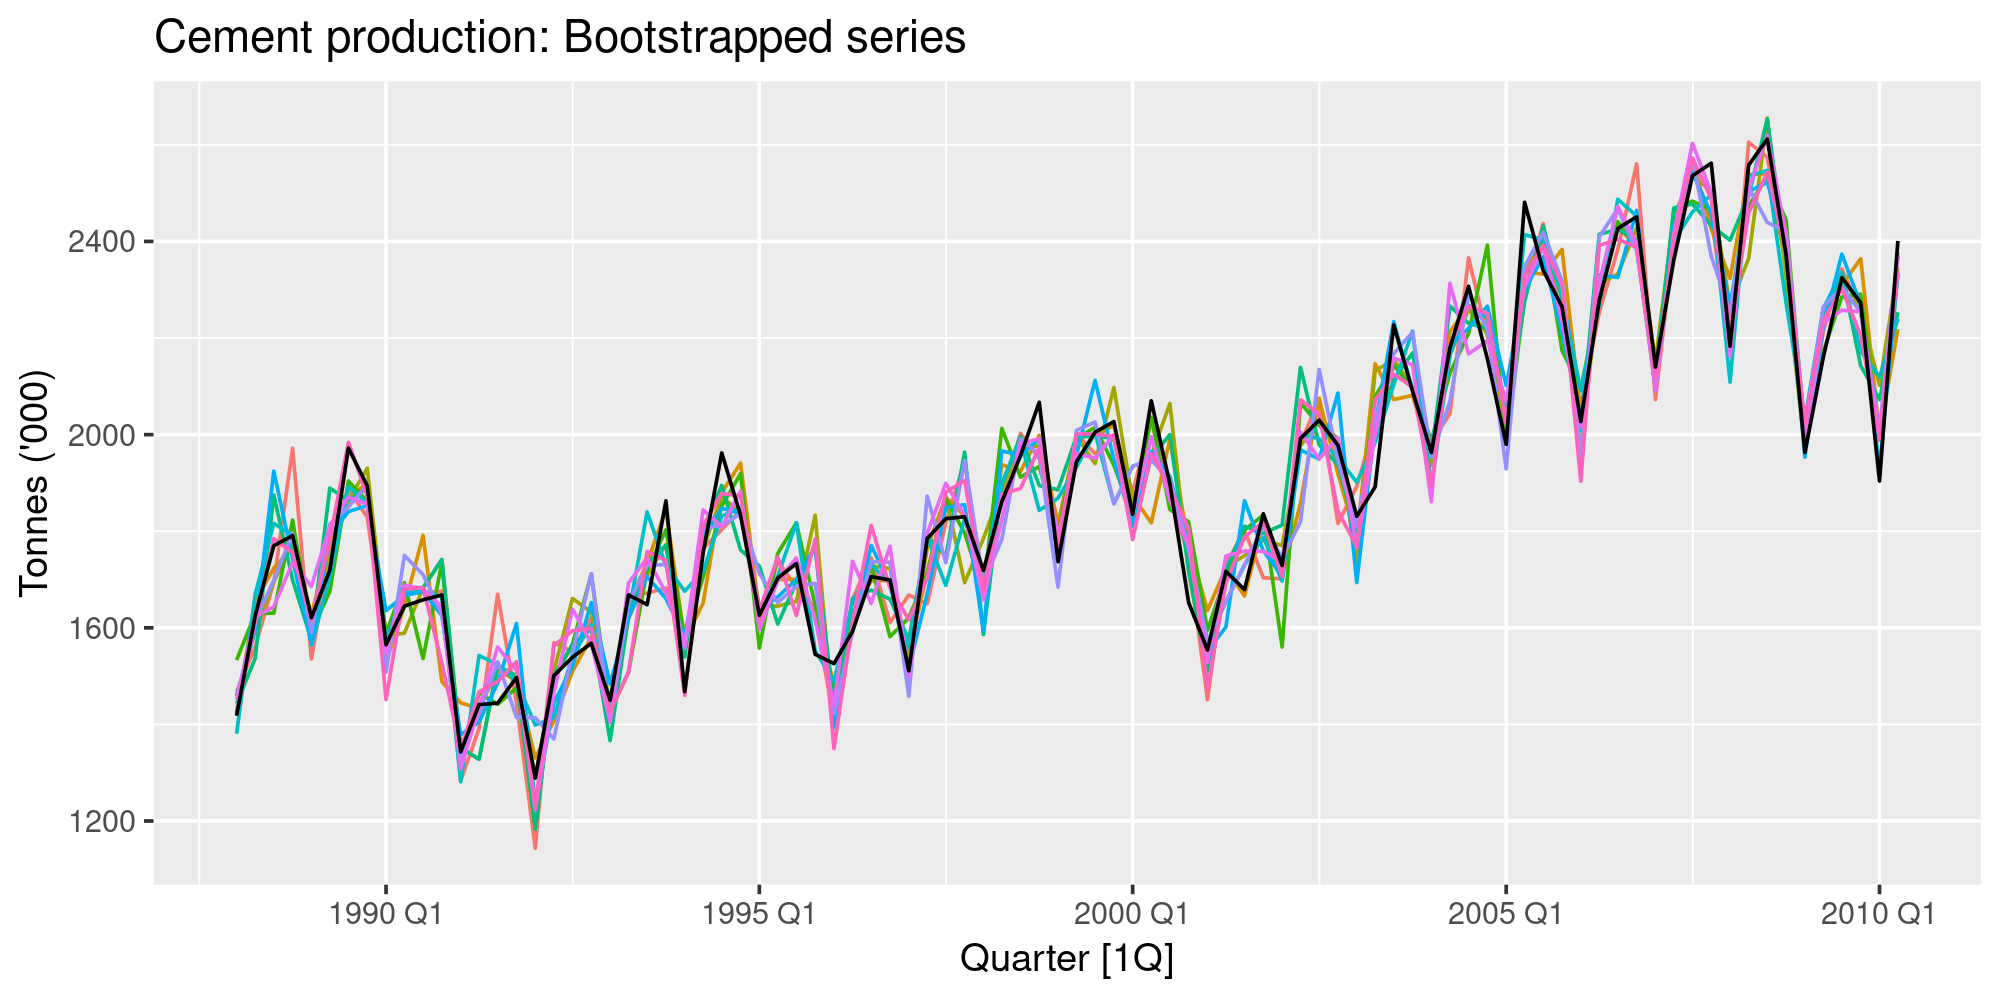

In [48]:
cement_boot |>
    autoplot(.sim) +
    autolayer(cement, Cement) +
        guides(colour = "none") +
        labs(title = "Cement production: Bootstrapped series", y="Tonnes ('000)")

## Bagged forecasts

One use for these bootstrapped time series is to improve forecast accuracy. 

If we produce forecasts from each of the additional time series, and average the resulting forecasts, we often get better forecasts than if we simply forecast the original time series directly. 

This is called “bagging” which stands for “bootstrap aggregating”.

We demonstrate the idea using the `cement` data.

First, we simulate many time series that are similar to the original data, using the block-bootstrap described above.

In [49]:
cement_sim <- cement_stl |>
    generate(new_data = cement, times = 10, bootstrap_block_size = 8) |>
    select(-.model, -Cement)

For each of these series, we fit an ETS model. 

A different ETS model may be selected in each case, although it will most likely select the same model because the series are similar. 

However, the estimated parameters will be different, so the forecasts will be different even if the selected model is the same. 

This is a time-consuming process as there are a large number of series.

In [50]:
ets_forecasts <- cement_sim |>
    model(ets = ETS(.sim)) |>
    forecast(h = 12)

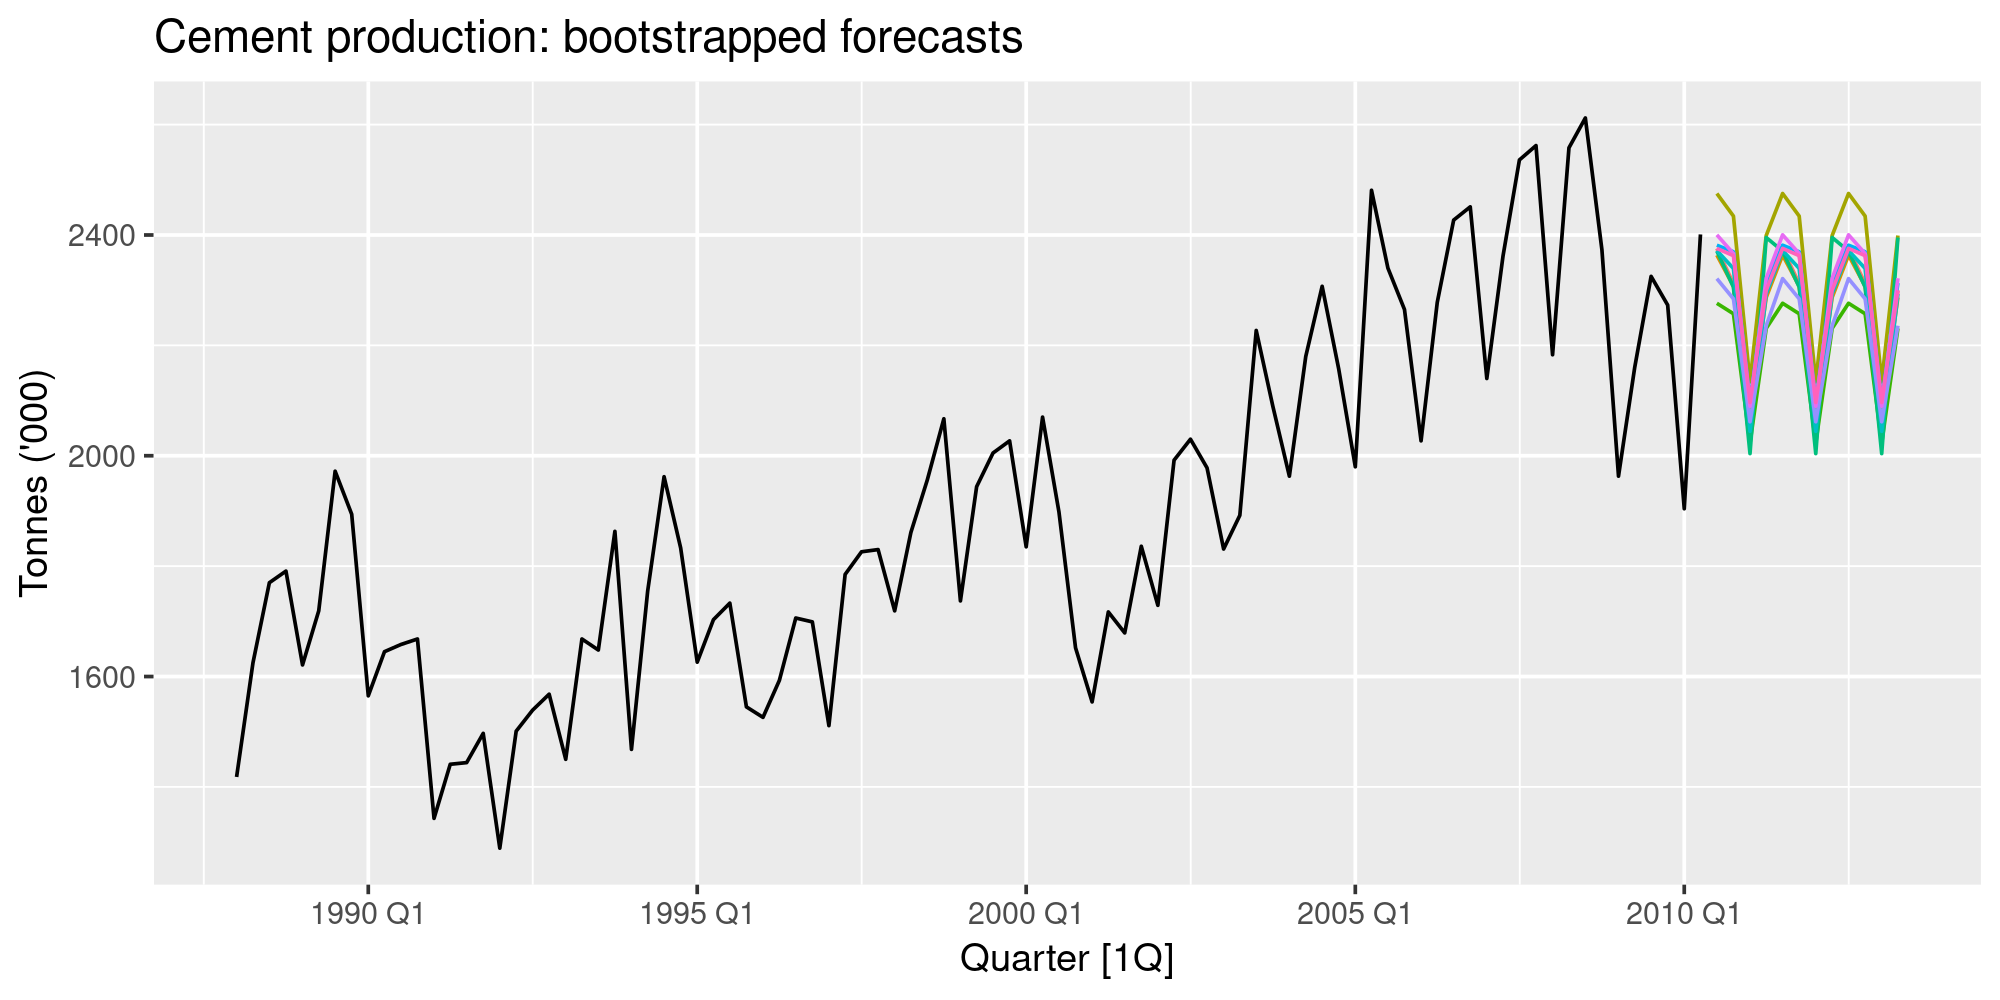

In [51]:
ets_forecasts |>
    update_tsibble(key = .rep) |>
    autoplot(.mean) +
    autolayer(cement, Cement) +
        guides(colour = "none") +
        labs(title = "Cement production: bootstrapped forecasts", y="Tonnes ('000)")

Finally, we average these forecasts for each time period to obtain the “bagged forecasts” for the original data.

In [52]:
bagged <- ets_forecasts |>
    summarise(bagged_mean = mean(.mean))

bagged

Quarter bagged_mean
1  2010 Q3 2371.141   
2  2010 Q4 2333.817   
3  2011 Q1 2068.675   
4  2011 Q2 2307.449   
5  2011 Q3 2371.141   
⋮  ⋮       ⋮          
8  2012 Q2 2307.449   
9  2012 Q3 2371.141   
10 2012 Q4 2333.818   
11 2013 Q1 2068.675   
12 2013 Q2 2307.449

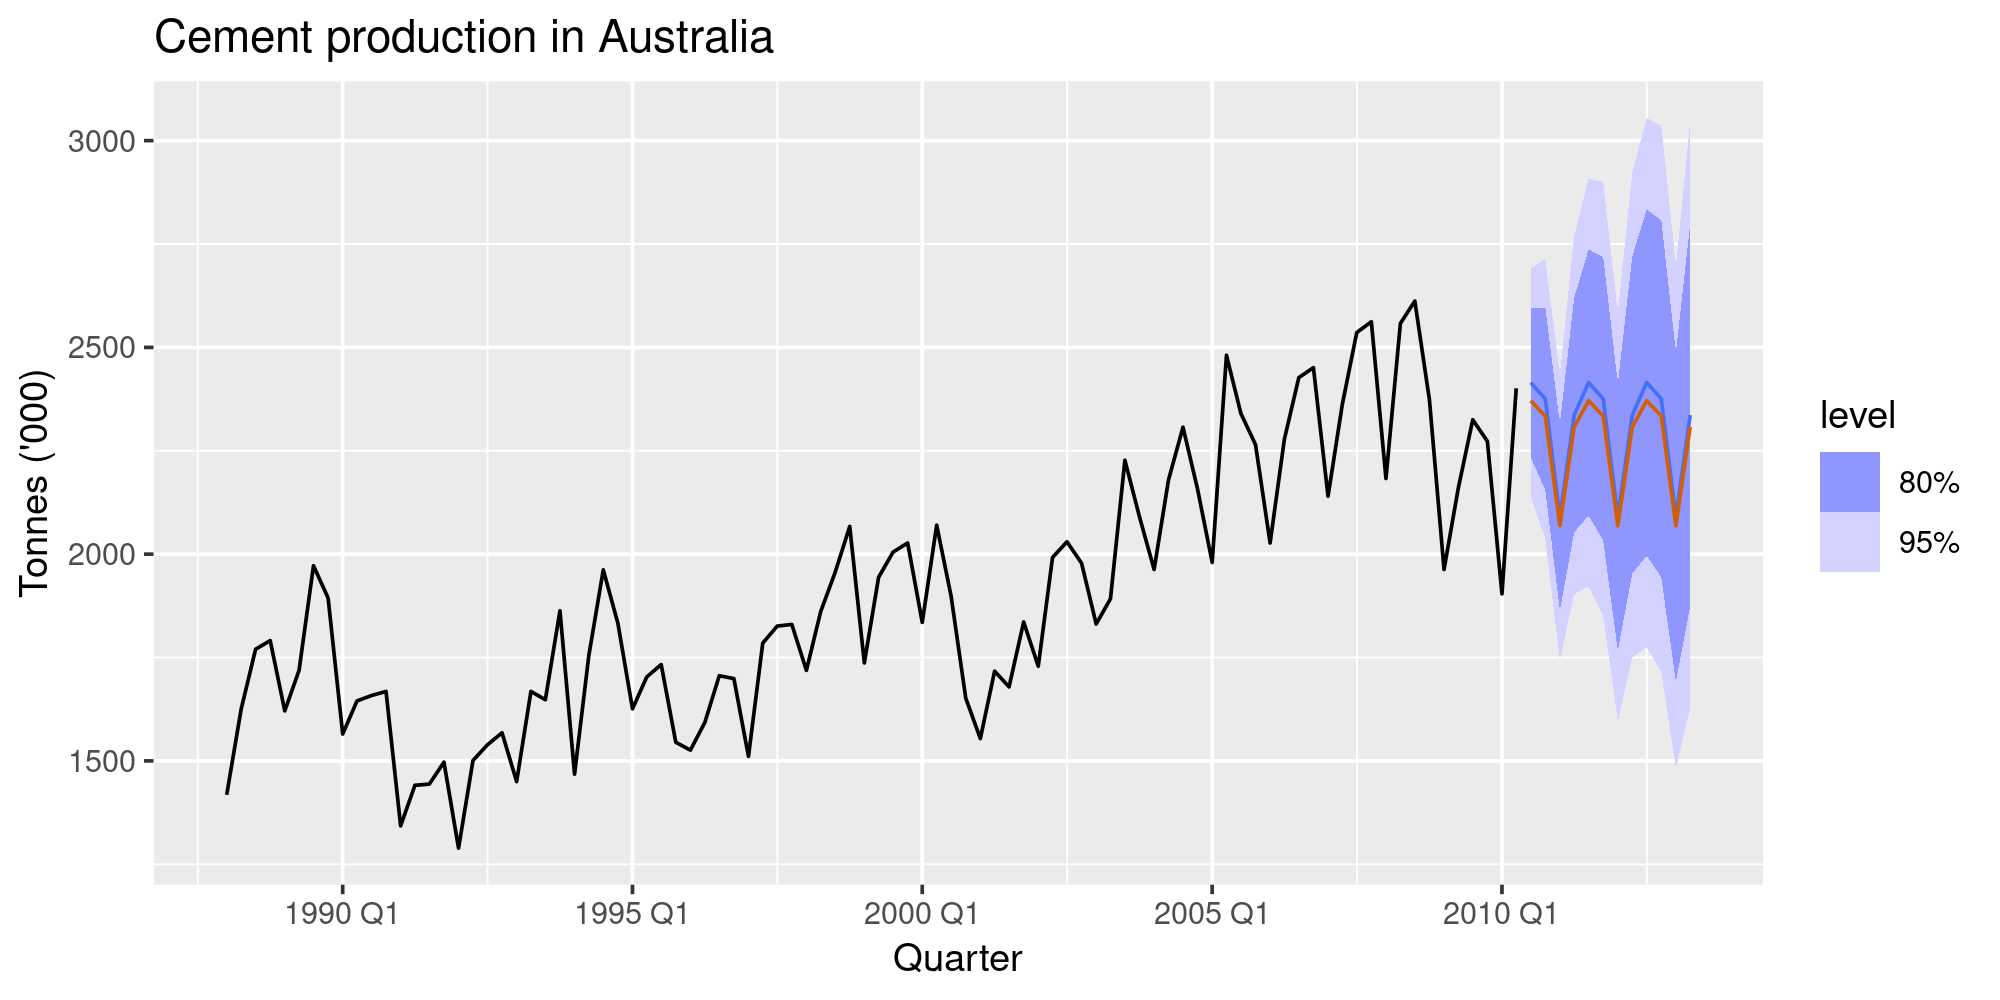

In [53]:
cement |>
    model(ets = ETS(Cement)) |>
    forecast(h = 12) |>
    autoplot(cement) +
    autolayer(bagged, bagged_mean, col = "#D55E00") +
        labs(title = "Cement production in Australia", y="Tonnes ('000)")

## Next time
 - Forecasting with Recurrent Neural Networks (RNN)
 - Forecasting with Long Short-Term Memory (LSTM)